# TCdata360 Data Census Analysis

In [336]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import datetime
import re
import io

from scipy import stats
import scipy.cluster.hierarchy as hac
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

## Set color palette

In [110]:
sns.set_style("darkgrid")

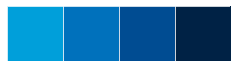

In [129]:
wbg_seq_pal = ["#009fda", '#0071bc', '#004c92', '#002245']
sns.palplot(sns.color_palette(wbg_seq_pal))

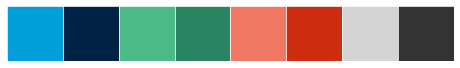

In [140]:
wbg_cat_pal = ["#009fda", '#002245', '#4cbb88', '#288462', '#f07761', '#cd2c0f', '#d4d4d4', '#333333']
sns.palplot(sns.color_palette(wbg_cat_pal))

# Data Preprocessing
## Loading Metadata

In [2]:
tc_datasets = 'http://tcdata360-backend.worldbank.org/api/v1/datasets'
df_tc_datasets = pd.read_json(requests.get(tc_datasets).text)

In [3]:
df_tc_datasets.head()

description   id                                              legal  \
0          NaN  590  For use guidelines, please consult PEFA (https...   
1          NaN   49  For use guidelines, please consult World Bank ...   
2          NaN   50  For use guidelines, please consult World Bank ...   
3          NaN   51  For use guidelines, please consult World Bank ...   
4          NaN   53  For use guidelines, please consult World Econo...   

                                                link  \
0               https://pefa.org/assessments/listing   
1                   http://www.enterprisesurveys.org   
2                           http://lpi.worldbank.org   
3  http://info.worldbank.org/governance/wgi/index...   
4  http://reports.weforum.org/global-competitiven...   

                              slug  \
0                             PEFA   
1               enterprise_surveys   
2      logistics_performance_index   
3  worldwide_governance_indicators   
4     global_competitiveness_index   

                                              source  \
0                                               PEFA   
1                           WBG - Enterprise Surveys   
2                  WBG - Logistics Performance Index   
3                    Worldwide Governance Indicators   
4  World Economic Forum Global Competitiveness Index   

                                               title  
0                                               PEFA  
1                                 Enterprise Surveys  
2                        Logistics Performance Index  
3                    Worldwide Governance Indicators  
4  World Economic Forum Global Competitiveness Index

In [258]:
df_tc_countries = pd.read_json(requests.get('http://tcdata360-backend.worldbank.org/api/v1/countries').text)

In [259]:
df_tc_countries.head()

adminRegion  aggregate       capitalCity  \
0         SAS      False             Kabul   
1         ECA      False            Tirane   
2         MNA      False           Algiers   
3         EAP      False         Pago Pago   
4        None      False  Andorra la Vella   

                                  geo   id incomeLevel iso2 iso3 lendingType  \
0    {'lat': 34.5228, 'lng': 69.1761}  AFG         LIC   AF  AFG         IDX   
1    {'lat': 41.3317, 'lng': 19.8172}  ALB         UMC   AL  ALB         IBD   
2    {'lat': 36.7397, 'lng': 3.05097}  DZA         UMC   DZ  DZA         IBD   
3  {'lat': -14.2846, 'lng': -170.691}  ASM         UMC   AS  ASM         LNX   
4     {'lat': 42.5075, 'lng': 1.5218}  AND         HIC   AD  AND         LNX   

             name region  
0     Afghanistan    SAS  
1         Albania    ECS  
2         Algeria    MEA  
3  American Samoa    EAS  
4         Andorra    ECS

## Normalizing Time data
For efficiency, we choose to normalize the data per dataset (instead of per country) since intra-dataset time periods are usually consistent.

### Defining Functions

In [78]:
# def normalize_dates(list_dates):
#     normed_dates = []
#     for x in list_dates:
#         cleaned_date = x
#         # for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
#         m = re.match('(\d{4})-(\d{4})', str(x))
#         if m:
#             cleaned_date = m.groups()[-1]
#         else: #for simplicity, we remap monthly/quarterly dates
#             n = re.match('(\d{4})Q\d{1}', str(x))
#             if n:
#                 cleaned_date = n.groups()[-1]
#             else:
#                 o = re.match('(\d{4})M\d{2}', str(x))
#                 if o:
#                     cleaned_date = o.groups()[-1]
#         normed_dates.append(cleaned_date)
#     return normed_dates

In [131]:
def normalize_dates(list_dates):
    normed_dates = []
    not_normed_list = []
    not_normed = False
    
    for x in list_dates:
        cleaned_date = x
        
        # for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
        m = re.match('(\d{4})-(\d{4})', str(x))
        m2 = re.match('(\d{4})-(\d{2})', str(x))
        if m:
            cleaned_date = m.groups()[0]
            not_normed = False
            
        elif m2:
            cleaned_date = m2.groups()[0]
            not_normed = False
                
        else: #for simplicity, we remap monthly/quarterly dates
            n = re.match('(\d{4})Q\d{1}', str(x))
            if n:
                cleaned_date = n.groups()[-1]
                not_normed = True
            else:
                o = re.match('(\d{4})M\d{2}', str(x))
                if o:
                    cleaned_date = o.groups()[-1]
                    not_normed = True
                    
        normed_dates.append(cleaned_date)
        not_normed_list.append(not_normed)
    return normed_dates, not_normed_list, sum(not_normed_list)

In [132]:
normalize_dates(['2011Q1', '2011-2012', '2013-14'])

(['2011', '2011', '2013'], [True, False, False], 1)

### Preprocess dataset (normalized time periods)
Assumptions for data preprocessing:
- for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
- for simplicity, we get the mean presence of monthly/quarterly dates (e.g., if only 1 of 4 quarterly data is available for that year, that year has the value 0.25)
- we also keep indicator-levels data only. Subindicators are removed from analysis since this might bloat counts for datasets with a lot of subindicators -- for instance, Doing Business data has DTF/Rank subindicator data for each indicator.

In [133]:
df_compiled = pd.DataFrame()
success_counter = 0
error_counter = 0
error_list = []
total_count = len(df_tc_datasets.index)

for row in df_tc_datasets.index:
# row = df_tc_datasets.index[0]
    id_dataset = df_tc_datasets['id'].iloc[row]
    title_dataset = df_tc_datasets['title'].loc[row]

    try:
        dat_url = "http://tcdata360-backend.worldbank.org/api/v1/datasets/" + str(id_dataset) + "/dump.csv"
        dat = requests.get(dat_url)
        df_dat = pd.read_csv(io.StringIO(dat.text))
        df_dat.drop(['Country Name', 'Subindicator Type'], axis=1, inplace=True)

        # Group columns by type: date, and non-date
        nondate_cols = ['Country ISO3', 'Country Name', 'Indicator', 'Subindicator Type', 'Partner', 'MRV', 'Product']
        list_nondate = [col for col in df_dat.columns if col in nondate_cols]
        list_timeframe = [col for col in df_dat.columns if col not in nondate_cols]

        #Convert date columns to boolean
        df_dat[list_timeframe] = df_dat[list_timeframe].notnull().replace({True:1.0, False:0.0})

        normed_dates, not_normed_list, not_normed = normalize_dates(list_timeframe)

        if not_normed > 0:
            df_temp = df_dat[list_nondate]

            # collate all possible dates
            pat = '(\d{4})Q\d{1}'
            df_grouped = df_dat.groupby(df_dat.columns.str.extract(pat, expand=False), axis=1)
            if bool(df_grouped.groups):
                for group in df_grouped.groups.keys():
                    df_temp[group] = df_grouped.get_group(group).mean(axis=1)
            else:
                pat = '(\d{4})M\d{2}'
                df_grouped = df_dat.groupby(df_dat.columns.str.extract(pat, expand=False), axis=1)
                if bool(df_grouped.groups):
                    for group in df_grouped.groups.keys():
                        df_temp[group] = df_grouped.get_group(group).mean(axis=1)
        else:
            df_temp = df_dat
            new_cols = list_nondate + list_timeframe
            df_temp = df_temp[new_cols]
            df_temp.columns = list_nondate + normed_dates

        df_temp['dataset_id'] = id_dataset
        df_compiled = df_compiled.append(df_temp)
    
        success_counter += 1
        print("Done checking %d out of %d datasets." % (success_counter + error_counter, total_count))

    except:
        error_counter += 1
        error_list.append([title_dataset, id_dataset])
        continue

print("Done with all %d datasets with %d successes and %d failures." % (total_count, success_counter, error_counter))
print("Failed datasets include %s" % str(error_list))

Done checking 1 out of 76 datasets.
Done checking 2 out of 76 datasets.
Done checking 3 out of 76 datasets.
Done checking 4 out of 76 datasets.
Done checking 5 out of 76 datasets.
Done checking 6 out of 76 datasets.
Done checking 7 out of 76 datasets.
Done checking 8 out of 76 datasets.
Done checking 9 out of 76 datasets.
Done checking 10 out of 76 datasets.
Done checking 11 out of 76 datasets.


C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done checking 12 out of 76 datasets.
Done checking 13 out of 76 datasets.
Done checking 14 out of 76 datasets.
Done checking 15 out of 76 datasets.
Done checking 16 out of 76 datasets.
Done checking 17 out of 76 datasets.


C:\Users\mrpso\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done checking 18 out of 76 datasets.
Done checking 19 out of 76 datasets.
Done checking 20 out of 76 datasets.
Done checking 21 out of 76 datasets.
Done checking 22 out of 76 datasets.
Done checking 23 out of 76 datasets.
Done checking 24 out of 76 datasets.
Done checking 25 out of 76 datasets.
Done checking 26 out of 76 datasets.
Done checking 27 out of 76 datasets.
Done checking 28 out of 76 datasets.
Done checking 29 out of 76 datasets.
Done checking 30 out of 76 datasets.
Done checking 31 out of 76 datasets.
Done checking 32 out of 76 datasets.
Done checking 33 out of 76 datasets.
Done checking 34 out of 76 datasets.
Done checking 35 out of 76 datasets.
Done checking 36 out of 76 datasets.
Done checking 37 out of 76 datasets.
Done checking 38 out of 76 datasets.
Done checking 39 out of 76 datasets.
Done checking 41 out of 76 datasets.
Done checking 42 out of 76 datasets.
Done checking 44 out of 76 datasets.
Done checking 45 out of 76 datasets.
Done checking 46 out of 76 datasets.
D

In [134]:
df_compiled.shape

(1204953, 115)

In [135]:
df_compiled.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928     ...      \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       

   2024  2025  2026  2027  Country ISO3  \
0   NaN   NaN   NaN   NaN           ABW   
1   NaN   NaN   NaN   NaN           ABW   
2   NaN   NaN   NaN   NaN           ABW   
3   NaN   NaN   NaN   NaN           ABW   
4   NaN   NaN   NaN   NaN           AFG   

                                           Indicator  MRV  Partner  Product  \
0  i Annual deviation of actual total HLG transfe...  NaN      NaN      NaN   
1  ii Annual variance between actual and estimate...  NaN      NaN      NaN   
2  iii Inyear timeliness of transfers from HLG co...  NaN      NaN      NaN   
3  Predictability of Transfers from Higher Level ...  NaN      NaN      NaN   
4  Aggregate expenditure outturn compared to orig...  NaN      NaN      NaN   

   dataset_id  
0         590  
1         590  
2         590  
3         590  
4         590  

[5 rows x 115 columns]

In [136]:
df_compiled.columns

Index(['1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927',
       '1928',
       ...
       '2024', '2025', '2026', '2027', 'Country ISO3', 'Indicator', 'MRV',
       'Partner', 'Product', 'dataset_id'],
      dtype='object', length=115)

In [4]:
nondate_cols = ['Country ISO3', 'Country Name', 'Indicator', 'Subindicator Type', 'Partner', 'MRV', 'Product']

In [5]:
nondate_cols_all = nondate_cols + ['dataset_id']
list_nondate_all = [col for col in df_compiled.columns if col in nondate_cols_all]
list_timeframe_all = [col for col in df_compiled.columns if col not in nondate_cols_all]

In [6]:
list_timeframe_all

['1919',
 '1920',
 '1921',
 '1922',
 '1923',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025',
 '2026',
 '2027']

In [149]:
df_compiled.reset_index(drop=True, inplace=True)

In [ ]:
df_compiled.to_csv("2017-08-05-TCdataset-complete.csv", index=False)

### Post-compilation Processing
- fill NA with 0
- drop duplicates (keep indicator-level data only)
- map indicators to Indicator ID
- map indicators to topics (we keep first hierarchy only)

In [7]:
df_compiled = pd.read_csv("2017-08-05-TCdataset-complete.csv")

C:\Users\mrpso\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_compiled[list_timeframe_all] = df_compiled[list_timeframe_all].replace({np.nan: 0.0})

In [9]:
df_compiled.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928     ...      \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       

   2024  2025  2026  2027  Country ISO3  \
0   0.0   0.0   0.0   0.0           ABW   
1   0.0   0.0   0.0   0.0           ABW   
2   0.0   0.0   0.0   0.0           ABW   
3   0.0   0.0   0.0   0.0           ABW   
4   0.0   0.0   0.0   0.0           AFG   

                                           Indicator  MRV  Partner  Product  \
0  i Annual deviation of actual total HLG transfe...  NaN      NaN      NaN   
1  ii Annual variance between actual and estimate...  NaN      NaN      NaN   
2  iii Inyear timeliness of transfers from HLG co...  NaN      NaN      NaN   
3  Predictability of Transfers from Higher Level ...  NaN      NaN      NaN   
4  Aggregate expenditure outturn compared to orig...  NaN      NaN      NaN   

   dataset_id  
0         590  
1         590  
2         590  
3         590  
4         590  

[5 rows x 115 columns]

In [10]:
df_compiled.drop_duplicates(inplace=True)

#### Merging Indicator and Nav lists for TC

In [11]:
df_tc_indicators = pd.read_json(requests.get('http://tcdata360-backend.worldbank.org/api/v1/indicators').text)
df_tc_indicators = df_tc_indicators[['datasetId', 'name', 'id']]
df_tc_indicators.drop_duplicates(subset=['datasetId', 'name'], inplace=True)

In [14]:
df_tc_nav = pd.read_csv("2017-08-07-TC-hierarchy.csv")
df_tc_nav = df_tc_nav.drop_duplicates(subset=['indicator.name'])[['indicator.name', 'level0.name','level1.name']]

In [47]:
df_tc_nav['name-lookup'] = df_tc_nav['indicator.name'].apply(lambda x: x.lower().strip())
df_tc_indicators['name-lookup'] = df_tc_indicators['name'].apply(lambda x: x.lower().strip())

In [48]:
df_tc_ind_nav = df_tc_indicators.merge(df_tc_nav, how='left', on='name-lookup')

#### Merging Indicator and Nav lists for Gov

In [40]:
df_gv_indicators = pd.read_json(requests.get('http://govdata360-backend.worldbank.org/api/v1/indicators').text)
df_gv_indicators = df_gv_indicators[['datasetId', 'name', 'id']]
df_gv_indicators.drop_duplicates(subset=['datasetId', 'name'], inplace=True)

In [41]:
df_gv_nav = pd.read_csv("2017-08-07-Gov-hierarchy.csv")
df_gv_nav = df_gv_nav.drop_duplicates(subset=['indicator.name'])[['indicator.name', 'level0.name','level1.name']]

In [49]:
df_gv_nav['name-lookup'] = df_gv_nav['indicator.name'].apply(lambda x: x.lower().strip())
df_gv_indicators['name-lookup'] = df_gv_indicators['name'].apply(lambda x: x.lower().strip())

In [51]:
df_gv_ind_nav = df_gv_indicators.merge(df_gv_nav, how='left', on='name-lookup')

In [52]:
df_ind_nav = pd.concat([df_tc_ind_nav, df_gv_ind_nav], axis=0).reset_index(drop=True)

In [53]:
df_ind_nav.to_csv("2017-08-07-TCGov-ind-hierarchy-merged.csv", index=False)

Import manually cleaned merged hierarchy-indicator list for TC and Gov

In [54]:
df_ind_nav = pd.read_csv("2017-08-07-TCGov-ind-hierarchy-merged-complete.csv")

In [60]:
df_ind_nav.columns = ['datasetId', 'name', 'indicatorId', 'name-lookup', 'indicator.name','topiclvl1', 'topiclvl2']

In [61]:
df_merged = df_compiled.merge(df_ind_nav, how='left', left_on=['dataset_id', 'Indicator'], right_on=['datasetId', 'name'])

In [68]:
df_merged = df_merged[df_merged['name'].notnull()]

In [70]:
df_merged[df_merged['indicator.name'].isnull()]

Empty DataFrame
Columns: [1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, ...]
Index: []

[0 rows x 122 columns]

#### Removing product- and partner-level indicators

In [213]:
df_merged.shape

(989910, 117)

In [215]:
df_merged.drop_duplicates(subset=['dataset_id', 'indicatorId', 'Country ISO3']).shape

(461127, 117)

In [216]:
df_merged2 = df_merged.drop_duplicates(subset=['dataset_id', 'indicatorId', 'Country ISO3'])

In [221]:
df_merged2.groupby('Country ISO3')['dataset_id'].value_counts().unstack(level=-1)

dataset_id     44   45    46    47     48     49   50   51    52     53   \
Country ISO3                                                               
ABW            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
AFG            2.0  3.0   NaN  22.0  112.0  121.0  7.0  6.0  65.0    NaN   
AGO            NaN  3.0   NaN  22.0  116.0  120.0  7.0  6.0  64.0  120.0   
ALB            4.0  3.0   NaN  23.0  112.0  121.0  7.0  6.0  65.0  120.0   
AND            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
ARE            4.0  3.0   NaN   NaN  118.0    NaN  7.0  6.0  65.0  119.0   
ARG           10.0  3.0   4.0  23.0  117.0  119.0  7.0  6.0  65.0  120.0   
ARM            6.0  3.0   NaN  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
ASM            NaN  NaN   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
ATG            1.0  3.0   NaN   NaN  110.0  103.0  NaN  6.0  65.0    NaN   
AUS           13.0  3.0  15.0   NaN  115.0    NaN  7.0  6.0  65.0  120.0   
AUT            2.0  3.0  19.0  23.0  116.0    NaN  7.0  6.0  65.0  120.0   
AZE            1.0  3.0   NaN  23.0  118.0  121.0  7.0  6.0  65.0  120.0   
BDI            3.0  3.0   NaN   NaN  120.0  121.0  7.0  6.0  65.0  119.0   
BEL            2.0  3.0  17.0   NaN  121.0    NaN  7.0  6.0  65.0  120.0   
BEN            3.0  3.0   NaN   NaN  117.0  120.0  7.0  6.0  65.0  120.0   
BFA            1.0  3.0   NaN  21.0  118.0  120.0  7.0  6.0  65.0  120.0   
BGD            NaN  3.0   NaN  23.0  118.0  121.0  7.0  6.0  59.0  120.0   
BGR            6.0  3.0   3.0  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
BHR            5.0  3.0   NaN   NaN  123.0    NaN  7.0  6.0  65.0  119.0   
BHS            NaN  3.0   NaN   NaN  107.0  107.0  7.0  6.0  65.0    NaN   
BIH            NaN  3.0   NaN  22.0  119.0  121.0  7.0  6.0  65.0  120.0   
BLR            NaN  3.0   NaN  23.0  115.0  121.0  7.0  6.0  65.0    NaN   
BLZ            2.0  3.0   NaN   NaN  108.0  105.0  NaN  6.0  65.0  112.0   
BMU            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
BOL            3.0  3.0   NaN  23.0  115.0  119.0  7.0  6.0  65.0  120.0   
BRA           12.0  3.0   8.0  23.0  118.0  119.0  7.0  6.0  59.0  120.0   
BRB            5.0  3.0   NaN   NaN  107.0  106.0  NaN  6.0  65.0  119.0   
BRN            3.0  3.0   NaN   NaN  111.0    NaN  7.0  6.0  65.0  120.0   
BTN            NaN  3.0   NaN   NaN  111.0  121.0  7.0  6.0  64.0  119.0   
...            ...  ...   ...   ...    ...    ...  ...  ...   ...    ...   
SYR            NaN  3.0   NaN   NaN  120.0  105.0  7.0  6.0  65.0  114.0   
TCA            NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN   NaN    NaN   
TCD            NaN  3.0   NaN   NaN  121.0  108.0  7.0  6.0  65.0  119.0   
TGO            3.0  3.0   NaN   NaN  119.0  120.0  7.0  6.0  65.0    NaN   
THA           11.0  3.0   NaN  23.0  113.0  119.0  7.0  6.0  65.0  120.0   
TJK            1.0  3.0   NaN   NaN  119.0  121.0  7.0  6.0  65.0  120.0   
TKM            NaN  3.0   NaN   NaN    NaN    NaN  7.0  6.0   NaN    NaN   
TLS            NaN  3.0   NaN   NaN  114.0  120.0  6.0  6.0  64.0  119.0   
TON            NaN  3.0   NaN   NaN  108.0  106.0  NaN  6.0  65.0    NaN   
TTO            5.0  3.0   NaN   NaN  113.0  119.0  7.0  6.0  65.0  119.0   
TUN            5.0  3.0   NaN  23.0  118.0  121.0  7.0  6.0  65.0  120.0   
TUR           13.0  3.0  16.0  23.0  112.0  121.0  7.0  6.0  65.0  120.0   
TUV            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
TZA            3.0  3.0   NaN  22.0  114.0  121.0  7.0  6.0  65.0  120.0   
UGA            3.0  3.0   NaN  22.0  119.0  121.0  7.0  6.0  65.0  120.0   
UKR           12.0  3.0   NaN  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
URY            9.0  3.0   NaN   NaN  116.0  119.0  7.0  6.0  65.0  120.0   
USA           15.0  3.0  18.0  23.0  113.0    NaN  7.0  6.0  59.0  120.0   
UZB            NaN  3.0   NaN   NaN  119.0  121.0  7.0  6.0  65.0    NaN   
VCT            3.0  3.0   NaN   NaN  110.0  107.

In [222]:
df_merged2.drop(['Partner', 'Product'], axis=1, inplace=True)

C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [224]:
df_merged2.reset_index(drop=True, inplace=True)

### Export as CSV, HDF5 files

In [71]:
df_merged.to_csv("2017-08-05-TCdataset-deduped-mapped-verbose.csv", index=False)

In [72]:
df_merged.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...                Partner  Product  dataset_id  datasetId  \
0              ...                    NaN      NaN         590      590.0   
1              ...                    NaN      NaN         590      590.0   
2              ...                    NaN      NaN         590      590.0   
3              ...                    NaN      NaN         590      590.0   
4              ...                    NaN      NaN         590      590.0   

                                                name  indicatorId  \
0  i Annual deviation of actual total HLG transfe...      27373.0   
1  ii Annual variance between actual and estimate...      27406.0   
2  iii Inyear timeliness of transfers from HLG co...      27336.0   
3  Predictability of Transfers from Higher Level ...      27358.0   
4  Aggregate expenditure outturn compared to orig...      27333.0   

                                         name-lookup  \
0  i annual deviation of actual total hlg transfe...   
1  ii annual variance between actual and estimate...   
2  iii inyear timeliness of transfers from hlg co...   
3  predictability of transfers from higher level ...   
4  aggregate expenditure outturn compared to orig...   

                                      indicator.name  \
0  i Annual deviation of actual total HLG transfe...   
1  ii Annual variance between actual and estimate...   
2  iii Inyear timeliness of transfers from HLG co...   
3  Predictability of Transfers from Higher Level ...   
4  Aggregate expenditure outturn compared to orig...   

                  topiclvl1                      topiclvl2  
0  Public Sector Management  Public Expenditure Management  
1  Public Sector Management  Public Expenditure Management  
2  Public Sector Management  Public Expenditure Management  
3  Public Sector Management  Public Expenditure Management  
4  Public Sector Management  Public Expenditure Management  

[5 rows x 122 columns]

In [74]:
df_merged.drop(['name-lookup','indicator.name', 'name','datasetId', 'Indicator'], axis=1,inplace=True)

In [85]:
df_merged.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...                2026  2027  Country ISO3  MRV  Partner  \
0              ...                 0.0   0.0           ABW  NaN      NaN   
1              ...                 0.0   0.0           ABW  NaN      NaN   
2              ...                 0.0   0.0           ABW  NaN      NaN   
3              ...                 0.0   0.0           ABW  NaN      NaN   
4              ...                 0.0   0.0           AFG  NaN      NaN   

   Product  dataset_id  indicatorId                 topiclvl1  \
0      NaN         590      27373.0  Public Sector Management   
1      NaN         590      27406.0  Public Sector Management   
2      NaN         590      27336.0  Public Sector Management   
3      NaN         590      27358.0  Public Sector Management   
4      NaN         590      27333.0  Public Sector Management   

                       topiclvl2  
0  Public Expenditure Management  
1  Public Expenditure Management  
2  Public Expenditure Management  
3  Public Expenditure Management  
4  Public Expenditure Management  

[5 rows x 117 columns]

In [86]:
df_merged.to_csv("2017-08-05-TCdataset-deduped-mapped.csv", index=False)

In [225]:
df_merged2.to_csv("2017-08-05-TCdataset-deduped-mapped-final.csv", index=False)

In [237]:
store = pd.HDFStore('TCdatacensusdata.h5')

In [238]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: TCdatacensusdata.h5
/df_tcdata                          frame_table  (typ->appendable,nrows->1204953,ncols->115,indexers->[index])
/df_tcdata_cleaned                  frame_table  (typ->appendable,nrows->989910,ncols->117,indexers->[index]) 
/df_tcdata_cleaned_final            frame_table  (typ->appendable,nrows->461127,ncols->115,indexers->[index]) 

In [239]:
store.is_open

True

In [231]:
df_merged2.to_hdf('TCdatacensusdata.h5', 'df_tcdata_cleaned_final', format = 'table')

In [240]:
store.close()

# Country-level Data Analysis

In [234]:
# df = pd.read_hdf('TCdatacensusdata.h5', 'df_tcdata_cleaned_final', where = 'index<100')

In [247]:
df_merged2[['indicatorId', 'Country ISO3', 'dataset_id']].duplicated().sum()

0

In [250]:
total_indicators = len(df_merged2['indicatorId'].unique())

In [257]:
total_indicators

4762

In [252]:
by_country = df_merged2.groupby('Country ISO3')[list_timeframe_all].sum()/total_indicators

In [253]:
by_country.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
Country ISO3                                                               
ABW            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
AFG            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
AGO            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ALB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
AND            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...        2018     2019     2020     2021     2022     2023  \
Country ISO3   ...                                                            
ABW            ...     0.00252  0.00252  0.00252  0.00252  0.00252  0.00252   
AFG            ...     0.00231  0.00231  0.00231  0.00231  0.00231  0.00000   
AGO            ...     0.00483  0.00483  0.00483  0.00483  0.00483  0.00252   
ALB            ...     0.00525  0.00525  0.00525  0.00525  0.00525  0.00252   
AND            ...     0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

                 2024     2025     2026     2027  
Country ISO3                                      
ABW           0.00252  0.00252  0.00252  0.00252  
AFG           0.00000  0.00000  0.00000  0.00000  
AGO           0.00252  0.00252  0.00252  0.00252  
ALB           0.00252  0.00252  0.00252  0.00252  
AND           0.00000  0.00000  0.00000  0.00000  

[5 rows x 109 columns]

In [261]:
df_tc_countries.set_index('id', inplace=True)

In [265]:
by_country = by_country.join(df_tc_countries[['region', 'incomeLevel', 'lendingType']], how='left')

In [117]:
# by_country_melt = pd.melt(by_country, id_vars=["Country ISO3"],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")

## Timeseries Plots

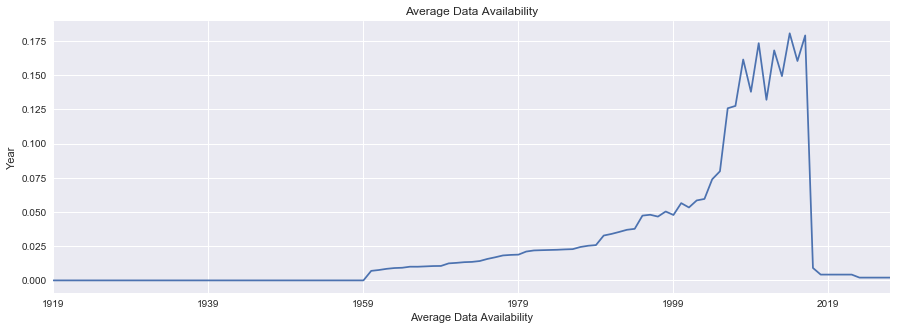

In [282]:
plt.title("Average Data Availability")
plt.ylabel("Year")
plt.xlabel("Average Data Availability")
by_country[list_timeframe_all].mean(axis=0).plot(figsize=(15,5))

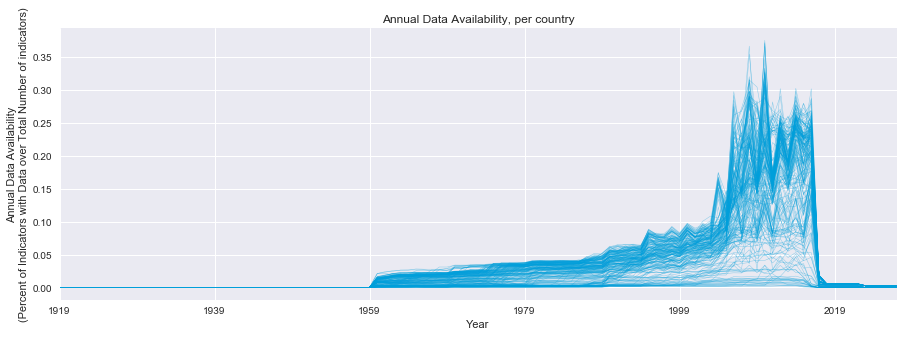

In [267]:
by_country[list_timeframe_all].T.plot(color='#009fda', lw=0.5, alpha=0.4, figsize=(15,5))
plt.title("Annual Data Availability, per country")
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")
plt.legend([])

In [391]:
by_country_melt.head()

Country ISO3 region incomeLevel lendingType  cluster Period  Observation
0          ABW    LCN         HIC         LNX        2   1919          0.0
1          AFG    SAS         LIC         IDX        2   1919          0.0
2          AGO    SSF         UMC         IBD        2   1919          0.0
3          ALB    ECS         UMC         IBD        2   1919          0.0
4          AND    ECS         HIC         LNX        2   1919          0.0

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



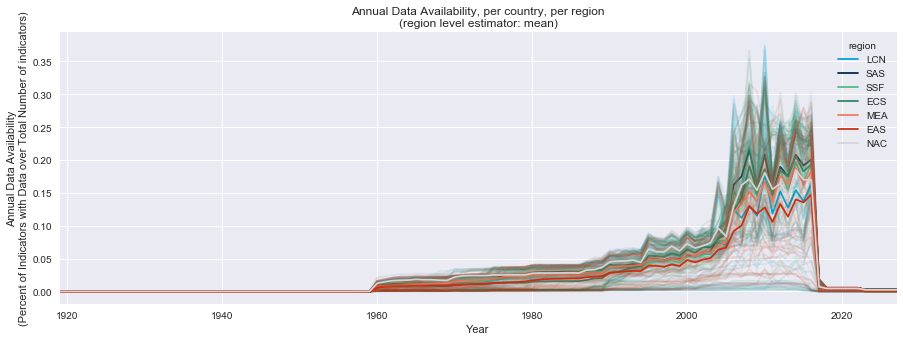

In [395]:
cond = 'region'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="unit_traces", err_kws = {'alpha': 0.1})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: mean)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



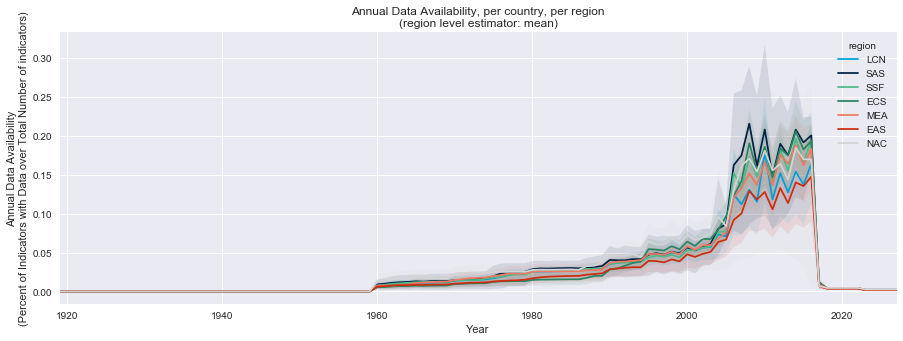

In [413]:
cond = 'region'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="ci_band", ci=[0,100], err_kws = {'alpha': 0.1})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: mean)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



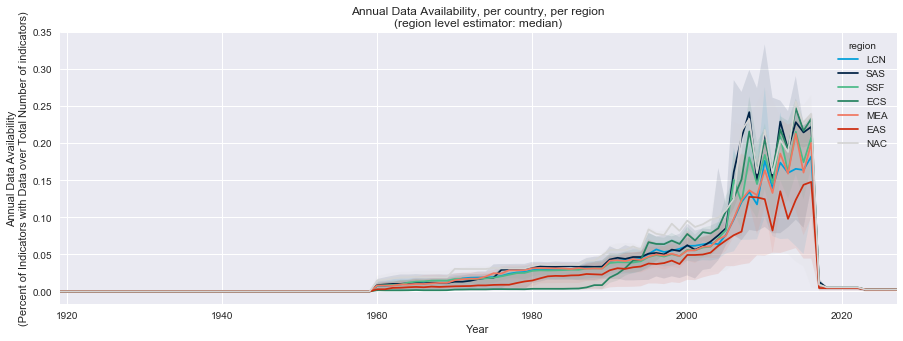

In [412]:
cond = 'region'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="ci_band", ci=[0,100], estimator=np.median, err_kws = {'alpha': 0.1})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: median)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



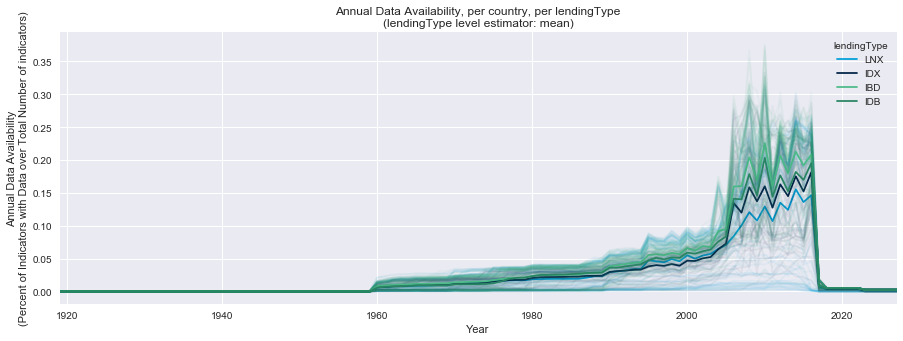

In [408]:
cond = 'lendingType'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="unit_traces", err_kws = {'alpha': 0.05})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: mean)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



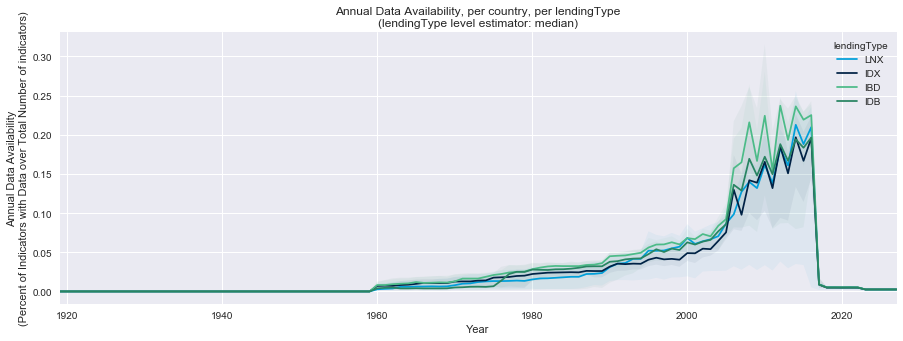

In [414]:
cond = 'lendingType'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="ci_band", ci=[0, 100], estimator=np.median,  err_kws = {'alpha': 0.05})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: median)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



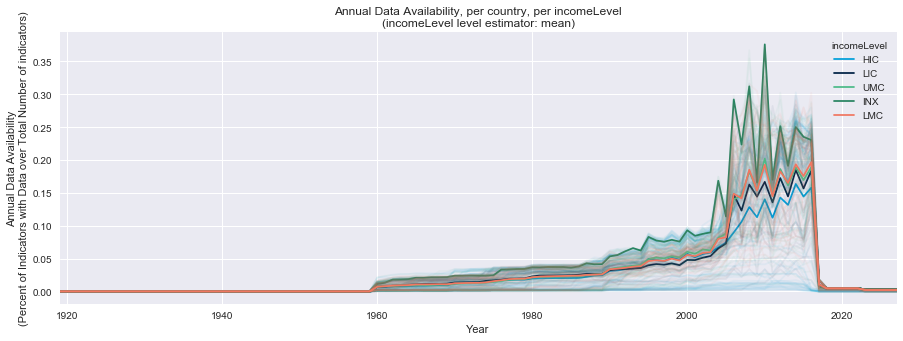

In [397]:
cond = 'incomeLevel'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="unit_traces", err_kws = {'alpha': 0.05})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: mean)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



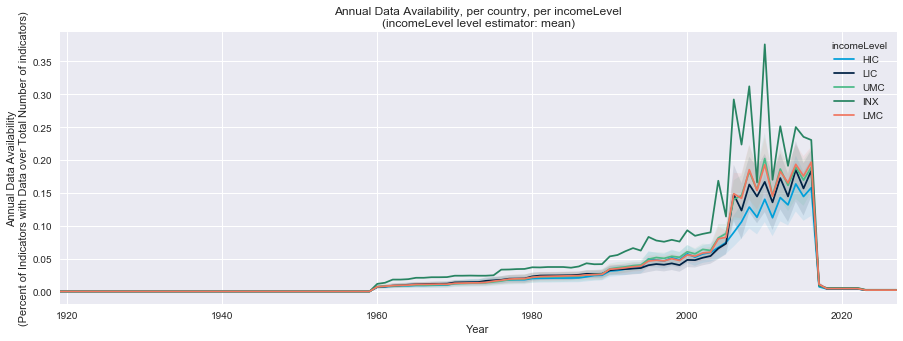

In [407]:
cond = 'incomeLevel'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="ci_band", ci=[0, 100], err_kws={'alpha':0.1})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: mean)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



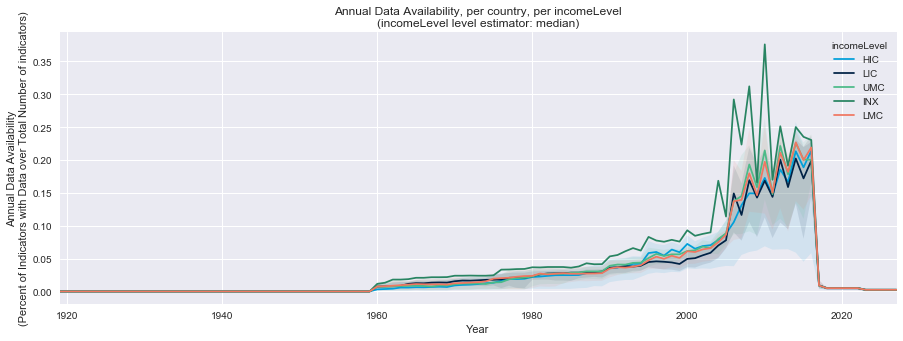

In [415]:
cond = 'incomeLevel'
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,
           color = wbg_cat_pal,err_style="ci_band", ci=[0, 100], estimator=np.median, err_kws={'alpha':0.1})
plt.title("Annual Data Availability, per country, per %s\n(%s level estimator: median)" % (cond, cond))
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")

In [420]:
by_country[by_country['incomeLevel'] == 'INX']

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
Country ISO3                                                               
ARG            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...        2022     2023     2024     2025     2026     2027  \
Country ISO3   ...                                                            
ARG            ...     0.00525  0.00252  0.00252  0.00252  0.00252  0.00252   

              region  incomeLevel  lendingType  cluster  
Country ISO3                                             
ARG              LCN          INX          IBD        2  

[1 rows x 113 columns]

## Histograms

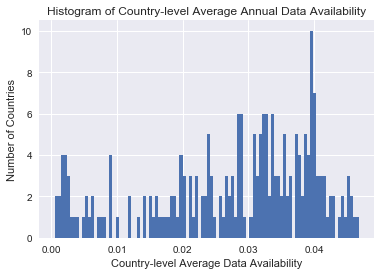

In [314]:
plt.title("Histogram of Country-level Average Annual Data Availability")
plt.ylabel("Number of Countries")
plt.xlabel("Country-level Average Data Availability")
map_by_country['ave_data_avail'].hist(bins=100)

In [423]:
by_country_melt.head()

Country ISO3 region incomeLevel lendingType  cluster Period  Observation
0          ABW    LCN         HIC         LNX        2   1919          0.0
1          AFG    SAS         LIC         IDX        2   1919          0.0
2          AGO    SSF         UMC         IBD        2   1919          0.0
3          ALB    ECS         UMC         IBD        2   1919          0.0
4          AND    ECS         HIC         LNX        2   1919          0.0

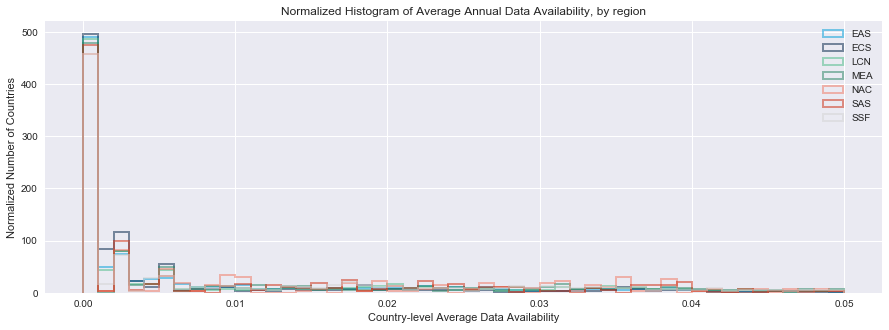

In [441]:
cond = 'region'
fig, ax = plt.subplots(figsize=(15,5))
df_grouped = by_country_melt.groupby(cond)[['Period', 'Observation']]
for label, group in df_grouped:
    group[['Period', 'Observation']].hist(bins = np.arange(0,0.051, 0.001), histtype='step', label = label, ax=ax, alpha=0.5, lw=2, normed=True)
plt.legend()
plt.title("Normalized Histogram of Average Annual Data Availability, by region")
plt.ylabel("Normalized Number of Countries")
plt.xlabel("Country-level Average Data Availability")
plt.show()

## Barplots

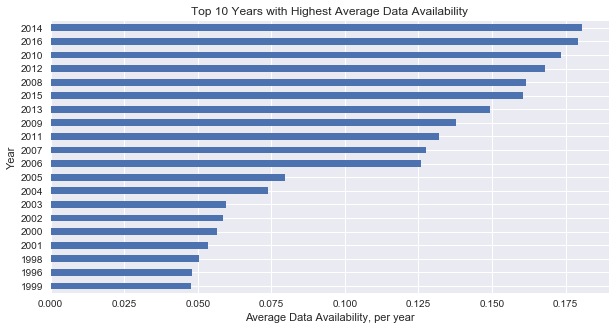

In [280]:
plt.title("Top 10 Years with Highest Average Data Availability")
plt.ylabel("Year")
plt.xlabel("Average Data Availability, per year")
by_country[list_timeframe_all].mean(axis=0).sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(10,5))

In [285]:
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=False).head(20)

Country ISO3
MEX    0.046828
IND    0.046272
COL    0.045572
USA    0.045482
TUR    0.045411
ARG    0.045150
IDN    0.044992
BRA    0.044633
KEN    0.044186
ZAF    0.044067
PHL    0.043743
ITA    0.042861
PAK    0.042771
PER    0.042495
CHL    0.042488
CAN    0.042129
FRA    0.041498
MYS    0.041455
DEU    0.041437
POL    0.041237
dtype: float64

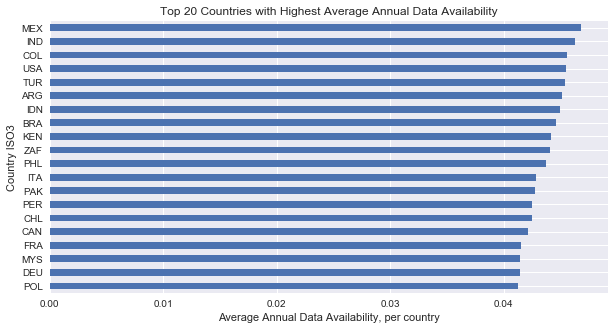

In [268]:
plt.title("Top 20 Countries with Highest Average Annual Data Availability")
plt.ylabel("Country ISO3")
plt.xlabel("Average Annual Data Availability, per country")
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(10,5))

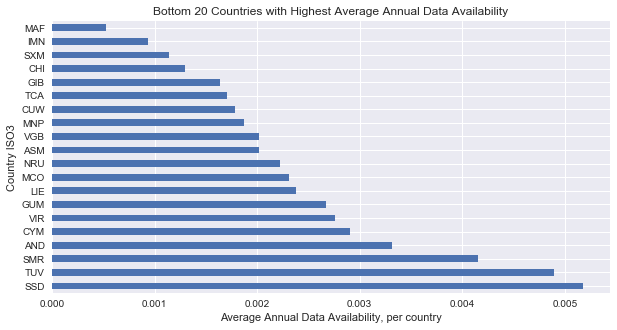

In [269]:
plt.title("Bottom 20 Countries with Highest Average Annual Data Availability")
plt.ylabel("Country ISO3")
plt.xlabel("Average Annual Data Availability, per country")
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=False).tail(20).plot(kind='barh', figsize=(10,5))

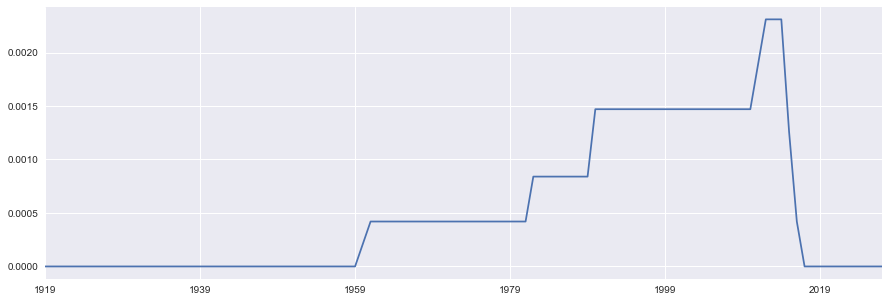

In [271]:
by_country.ix['MAF'][list_timeframe_all].plot(figsize=(15,5))

## Clustering country-level timeseries

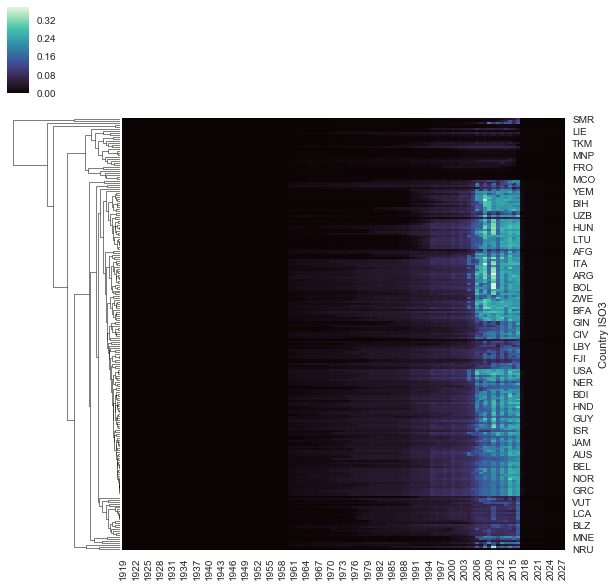

In [559]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', col_cluster=False)

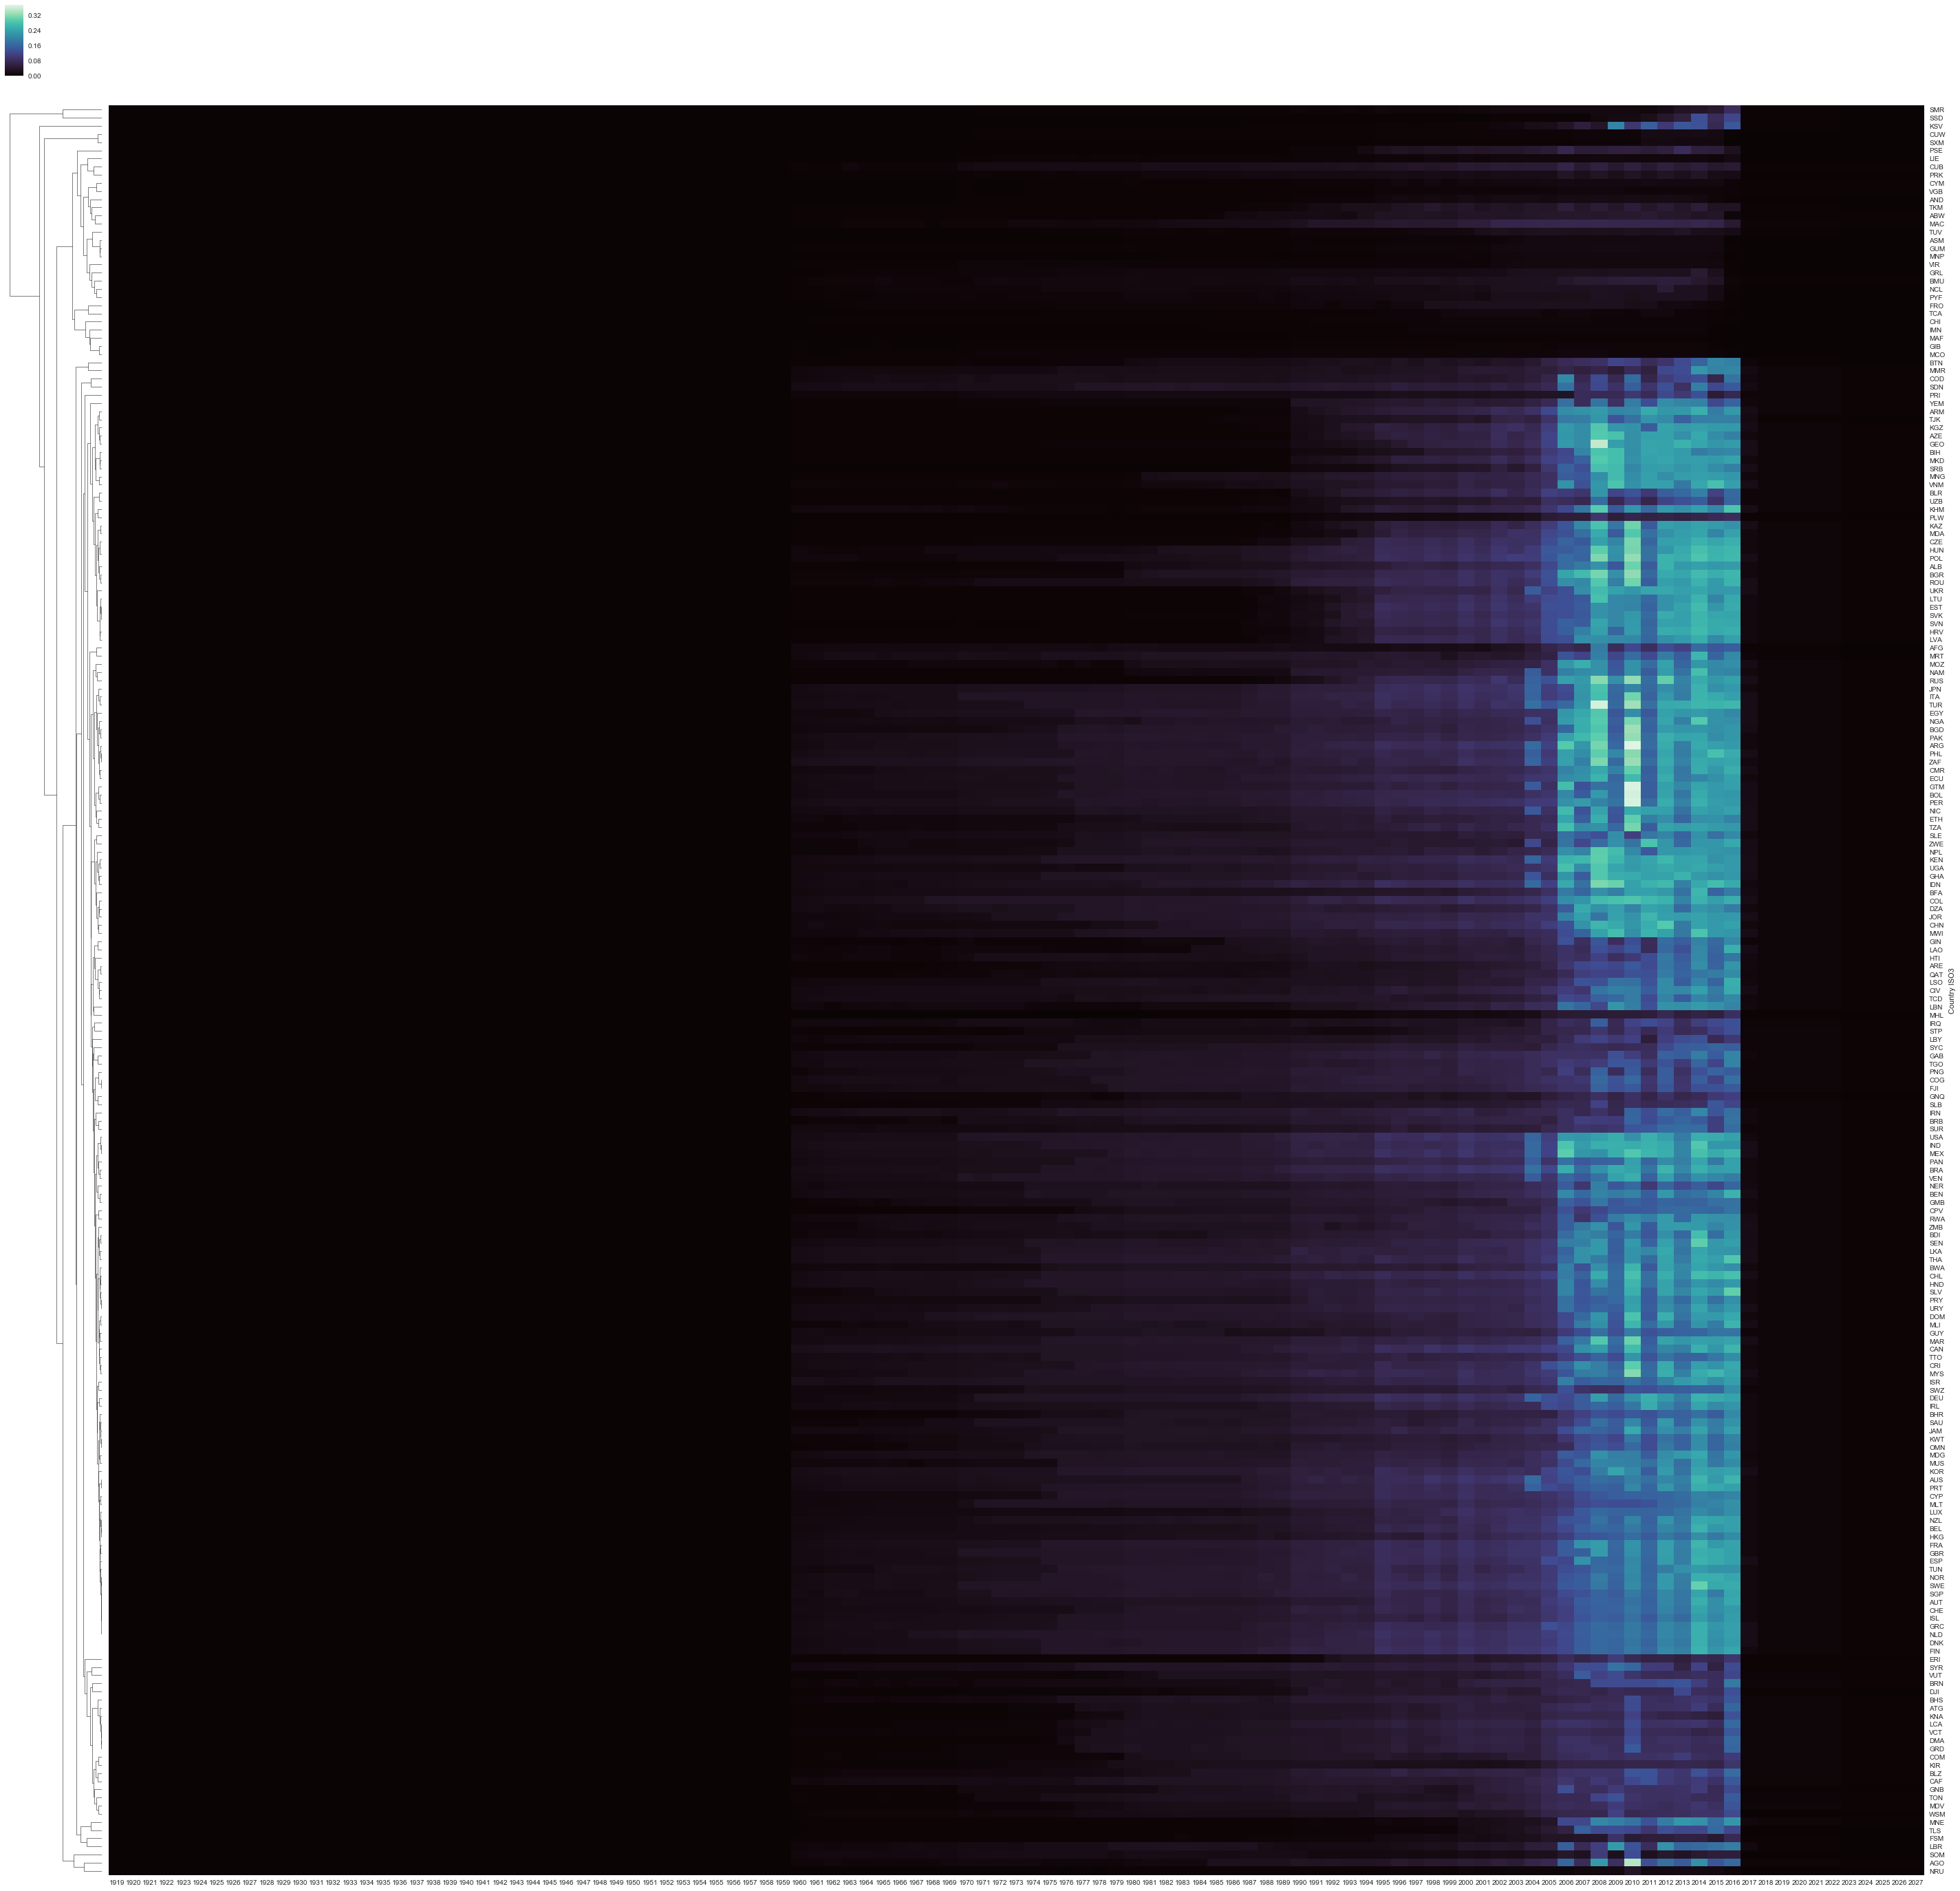

In [557]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', col_cluster=False, figsize=(50,50))

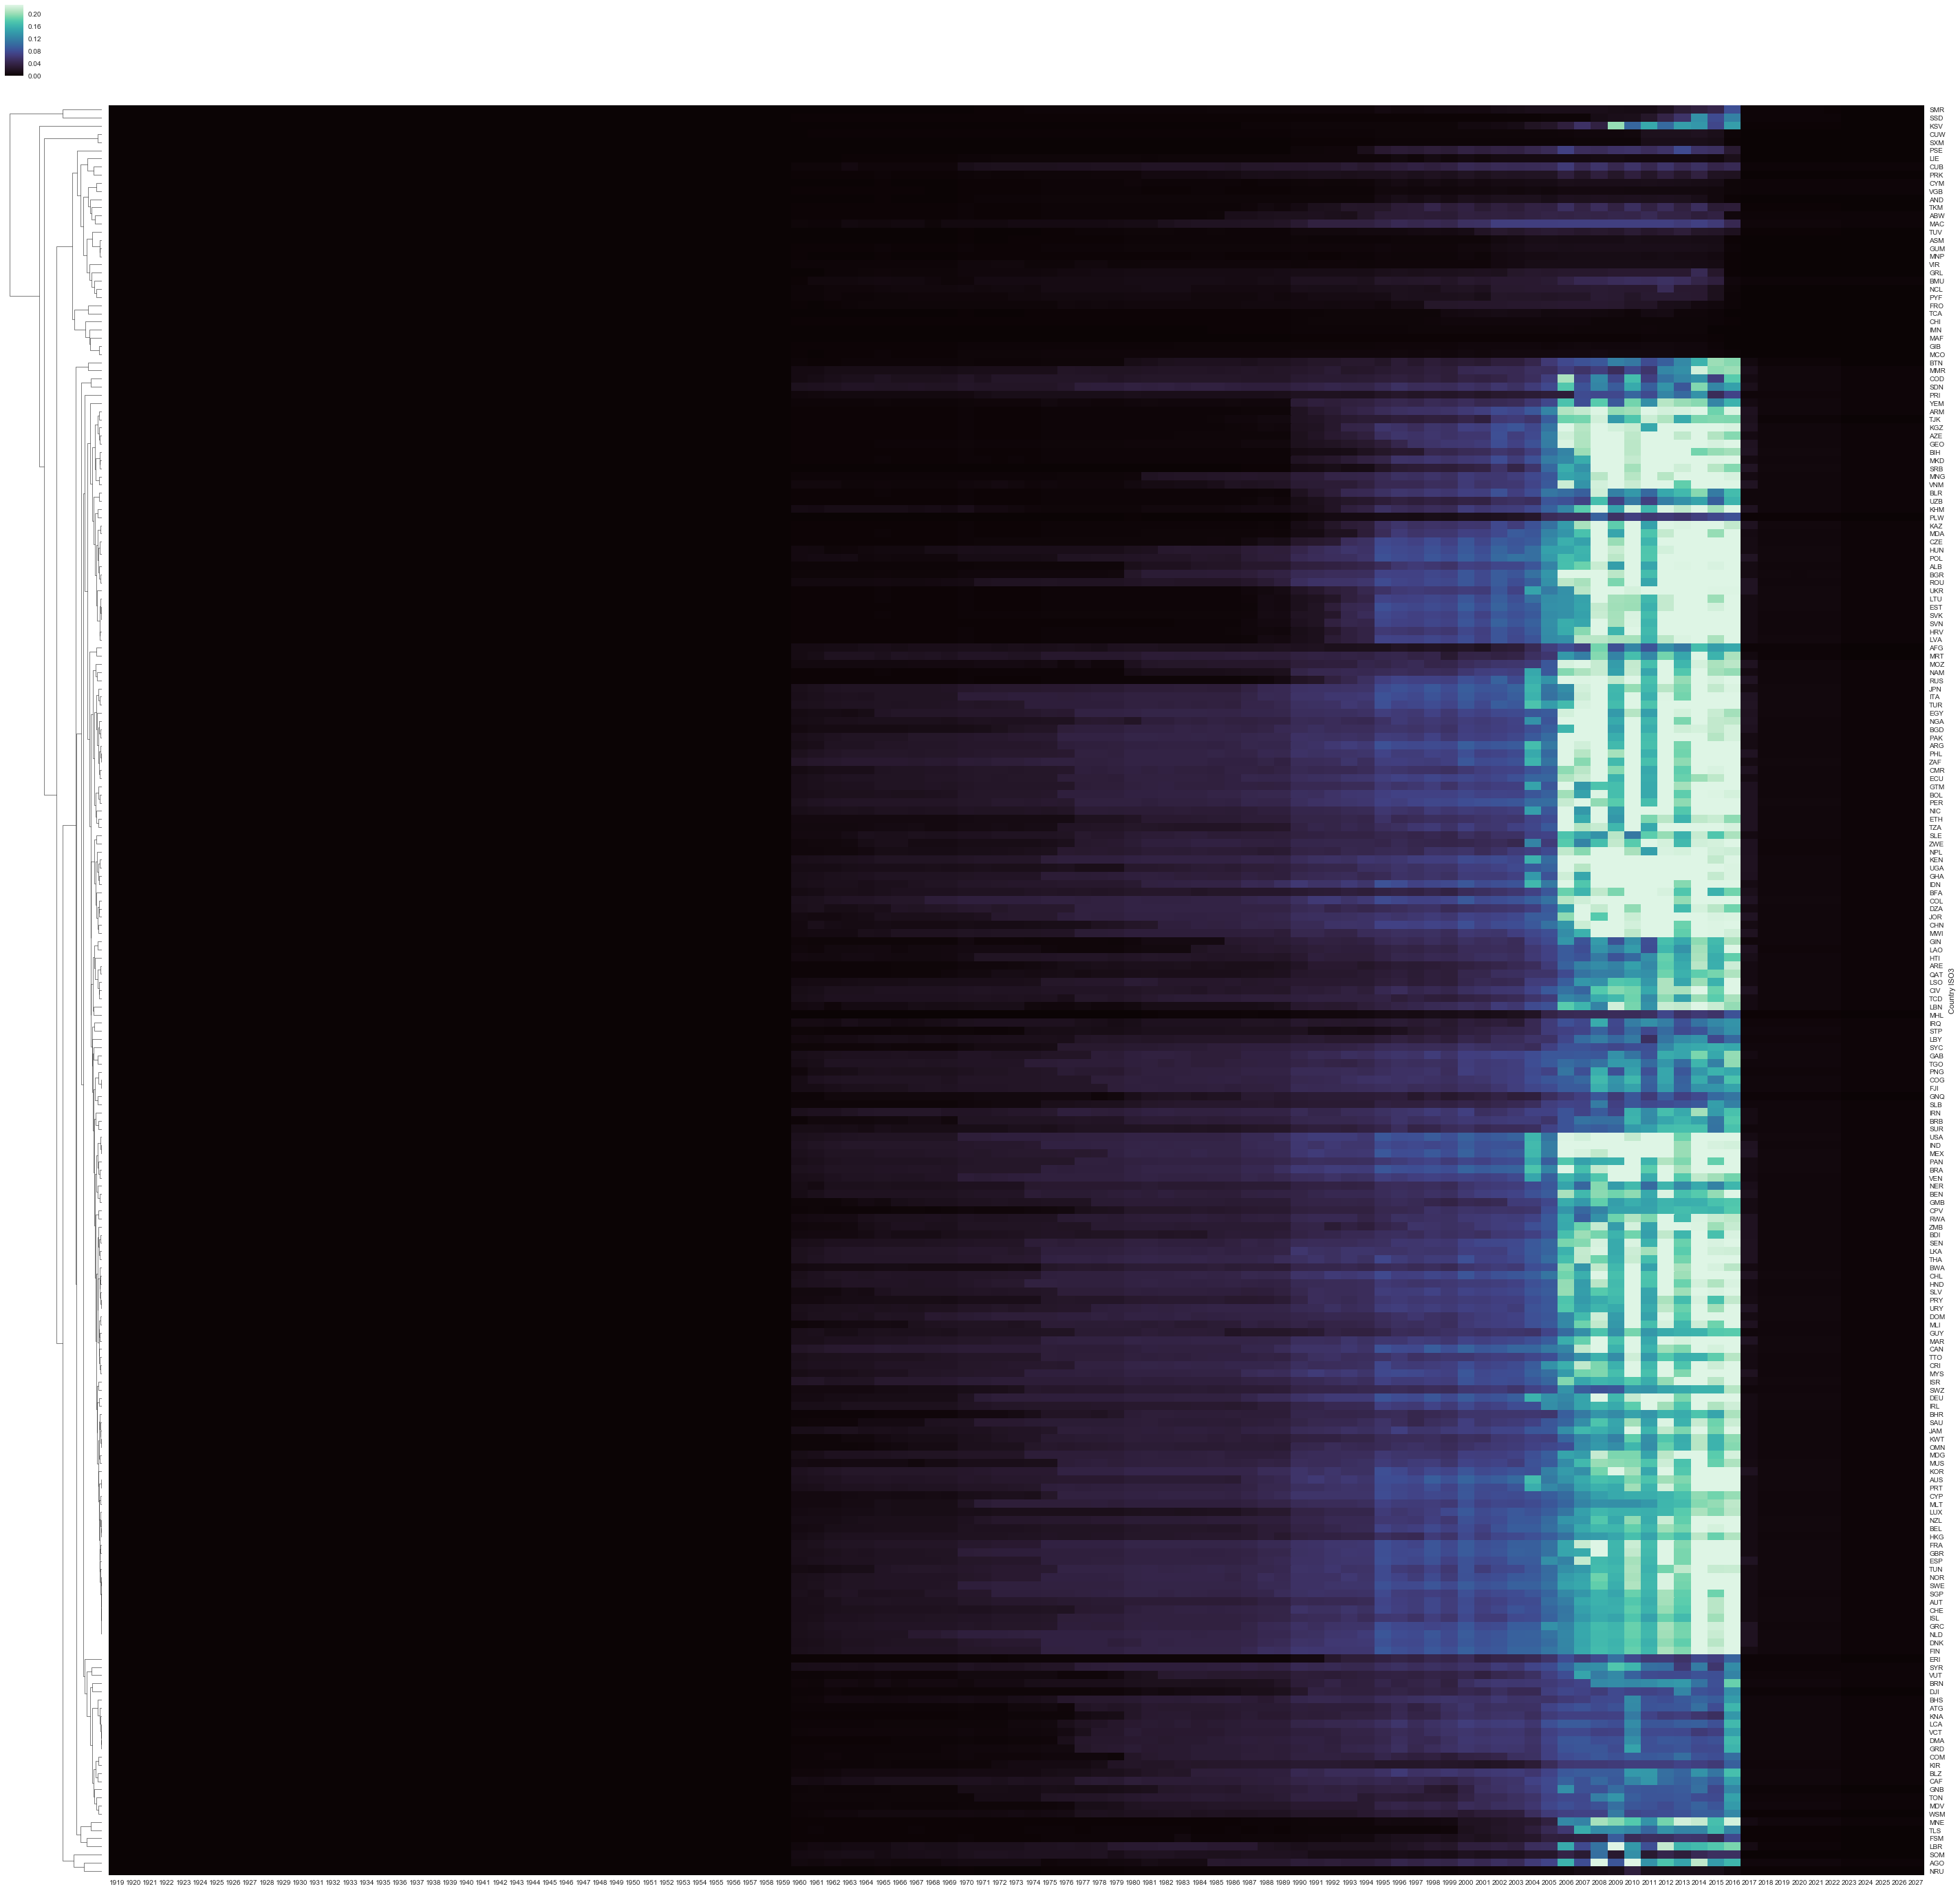

In [558]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', robust=True, col_cluster=False, figsize=(50,50)) #ignores outliers

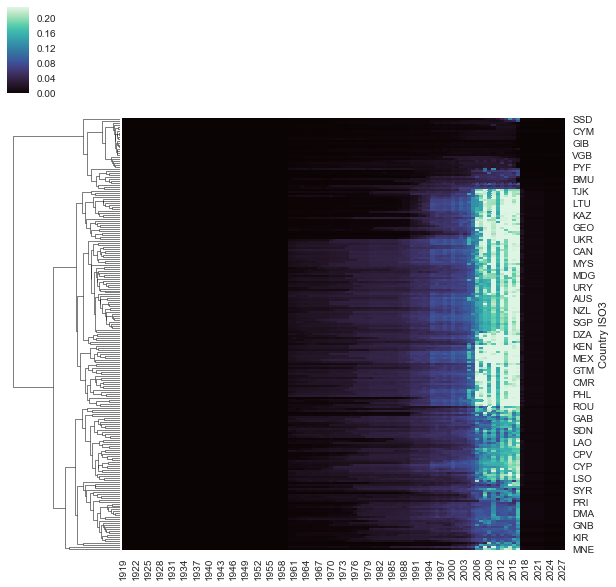

In [484]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", robust=True, col_cluster=False) #ignores outliers

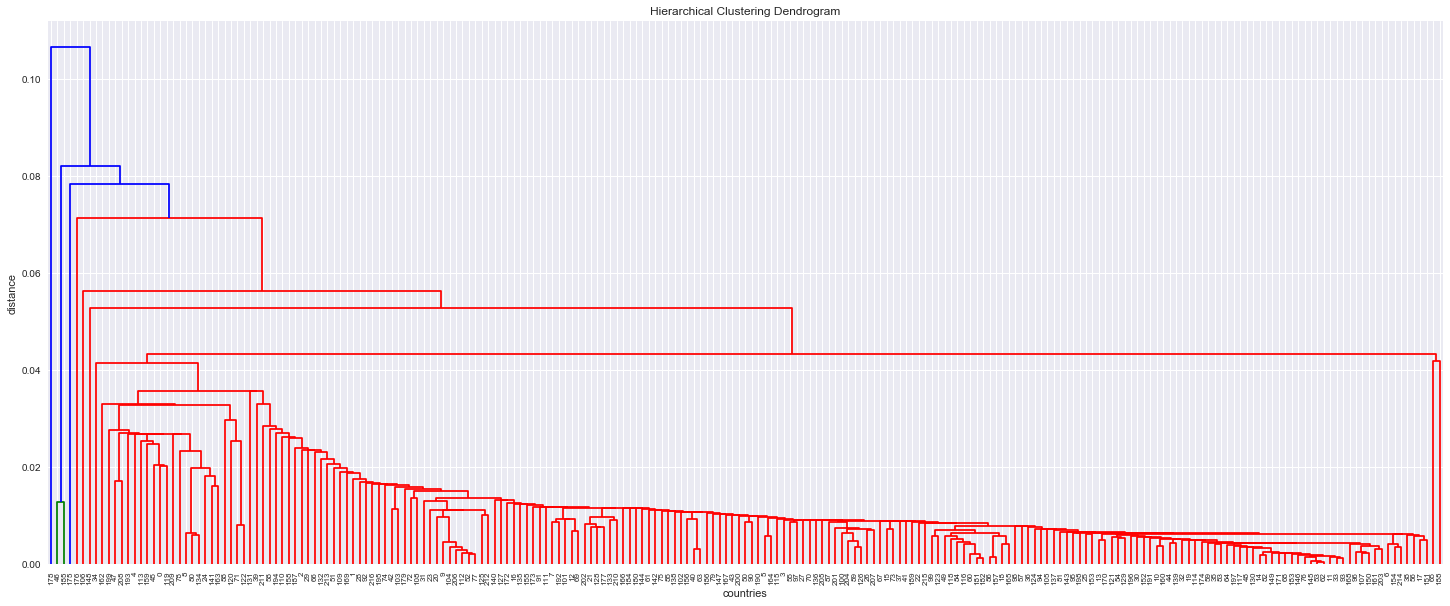

In [560]:
Z = hac.linkage(by_country[list_timeframe_all], 'single', 'cosine')

# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

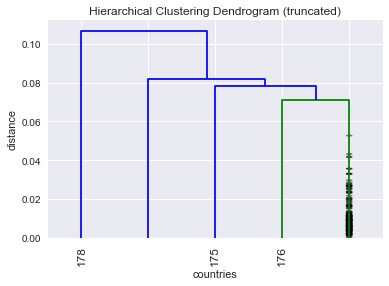

In [562]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

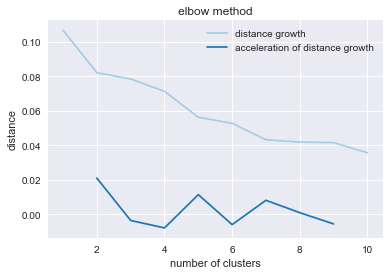

clusters: 2


In [561]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label='distance growth')

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label="acceleration of distance growth")
plt.legend()
plt.xlabel("number of clusters")
plt.ylabel("distance")
plt.title("elbow method")
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



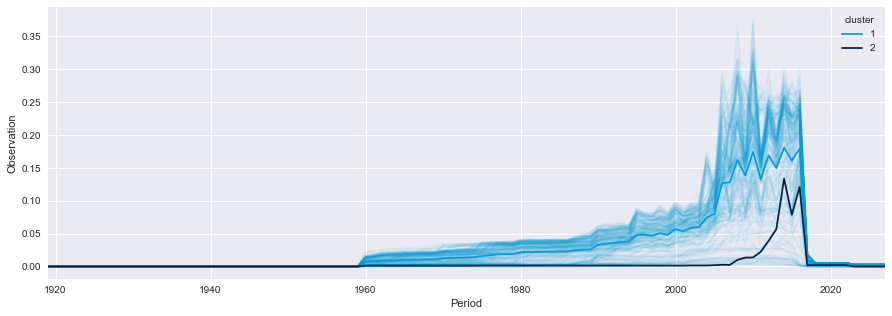

In [563]:
k=2
max_d = 0.05
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_country['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.05})

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



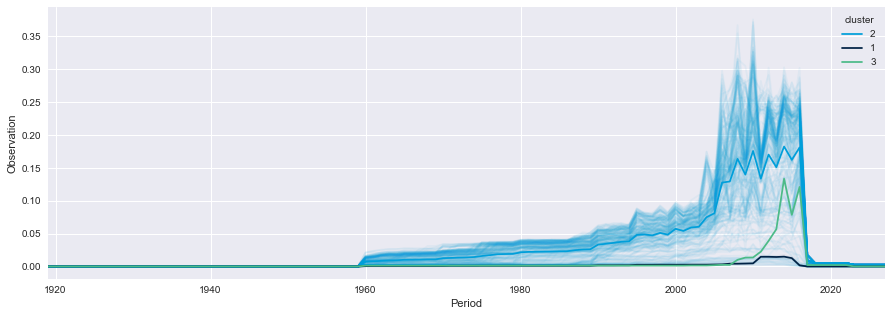

In [567]:
k=3
max_d = 0.038
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_country['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.05})

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



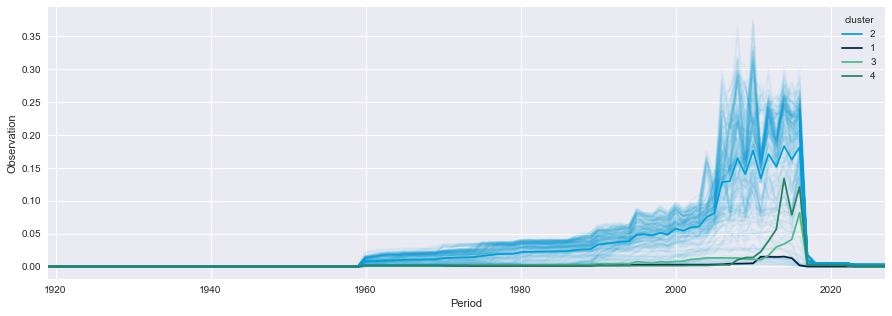

In [565]:
k=4
max_d = 0.05
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_country['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.05})

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



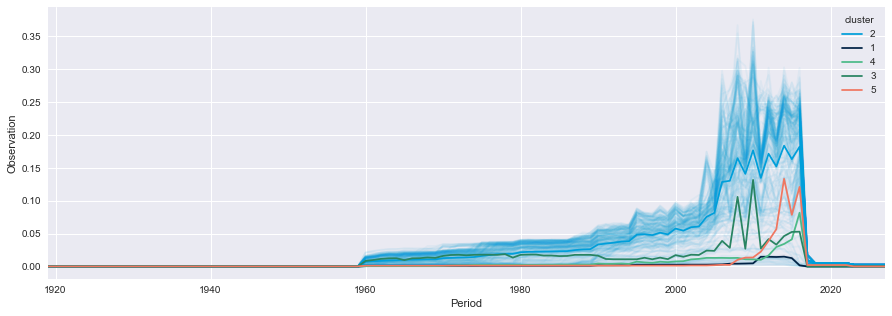

In [566]:
k=5
max_d = 0.05
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_country['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.05})

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



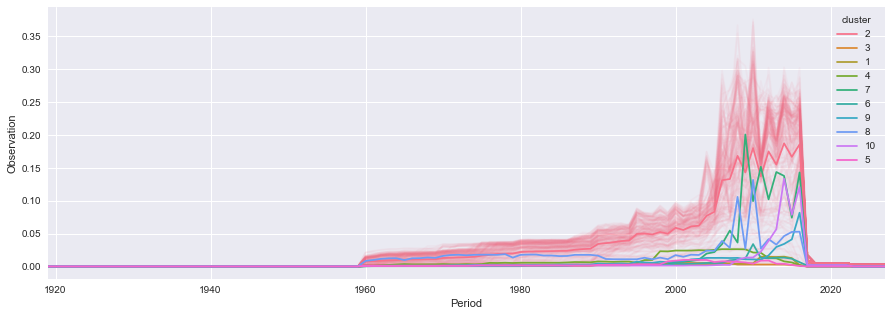

In [568]:
k=5
max_d = 0.038
by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
# by_country['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
           err_style="unit_traces", err_kws = {'alpha': 0.05})

### Looking into cluster k = 5

In [569]:
by_country['cluster'].value_counts()

2     207
1       2
10      1
9       1
8       1
7       1
6       1
5       1
4       1
3       1
Name: cluster, dtype: int64

In [570]:
by_country[by_country['cluster'] != 2]['cluster']

Country ISO3
CHI     3
CUW     1
FRO     4
KSV     7
NRU     6
SMR     9
SOM     8
SSD    10
SXM     1
TCA     5
Name: cluster, dtype: int32

## Choropleth Map

In [288]:
map_by_country = by_country[list_timeframe_all].mean(axis=1)
map_by_country = pd.concat([map_by_country, df_tc_countries['name']], axis=1)
map_by_country = map_by_country.reset_index()
map_by_country.columns = ['iso3', 'ave_data_avail', 'name']

In [303]:
map_by_country.head()

iso3  ave_data_avail         name
0  ABW        0.008940        Aruba
1  AFG        0.019709  Afghanistan
2  AGO        0.026687       Angola
3  ALB        0.033249      Albania
4  AND        0.003310      Andorra

In [309]:
init_notebook_mode(connected=True)

In [322]:
data = [ dict(
        type = 'choropleth',
        locations = map_by_country['iso3'],
        z = map_by_country['ave_data_avail'],
        text = map_by_country['name'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.25,"rgb(70, 100, 245)"],[0.5,"rgb(106, 137, 247)"],[1.0,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            ticksuffix = '%',
            title = 'Ave. Annual<br>Data Availability<br>Percent(%)'),
      ) ]

layout = dict(
    title = 'Average Annual Data Availability, by Country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

# Topic-level Data Analysis

In [485]:
df_merged2.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...                2024  2025  2026  2027  Country ISO3  MRV  \
0              ...                 0.0   0.0   0.0   0.0           ABW  NaN   
1              ...                 0.0   0.0   0.0   0.0           ABW  NaN   
2              ...                 0.0   0.0   0.0   0.0           ABW  NaN   
3              ...                 0.0   0.0   0.0   0.0           ABW  NaN   
4              ...                 0.0   0.0   0.0   0.0           AFG  NaN   

   dataset_id  indicatorId                 topiclvl1  \
0         590      27373.0  Public Sector Management   
1         590      27406.0  Public Sector Management   
2         590      27336.0  Public Sector Management   
3         590      27358.0  Public Sector Management   
4         590      27333.0  Public Sector Management   

                       topiclvl2  
0  Public Expenditure Management  
1  Public Expenditure Management  
2  Public Expenditure Management  
3  Public Expenditure Management  
4  Public Expenditure Management  

[5 rows x 115 columns]

In [497]:
total_indicators_per_topic = df_merged2.groupby(['topiclvl1'])['indicatorId'].apply(lambda x: len(x.unique()))

In [520]:
by_topic = (df_merged2.groupby(['topiclvl1', 'Country ISO3'])[list_timeframe_all].sum().unstack(level=0).fillna(0).mean().unstack(level=-1)/total_indicators_per_topic).T

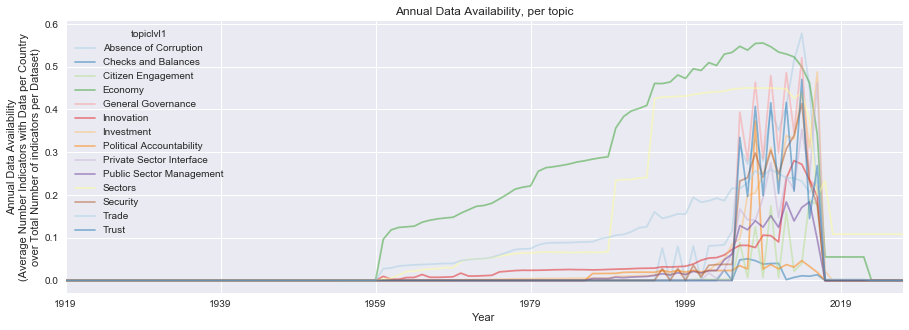

In [550]:
sns.set_palette(sns.color_palette("Paired", 16))
by_topic[list_timeframe_all].T.plot(figsize=(15,5), alpha=0.5)
plt.title("Annual Data Availability, per topic")
plt.ylabel("Annual Data Availability\n(Average Number Indicators with Data per Country\nover Total Number of indicators per Dataset)")
plt.xlabel("Year")

In [534]:
tc_topics = by_topic[by_topic.index.isin(['Trade', 'Innovation', 'Investment', 'Economy' , 'Sectors'])]
gv_topics = by_topic[~by_topic.index.isin(['Trade', 'Innovation', 'Investment', 'Economy' , 'Sectors'])]

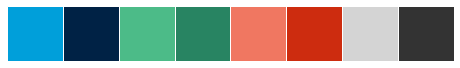

In [531]:
sns.palplot(sns.color_palette(wbg_cat_pal))

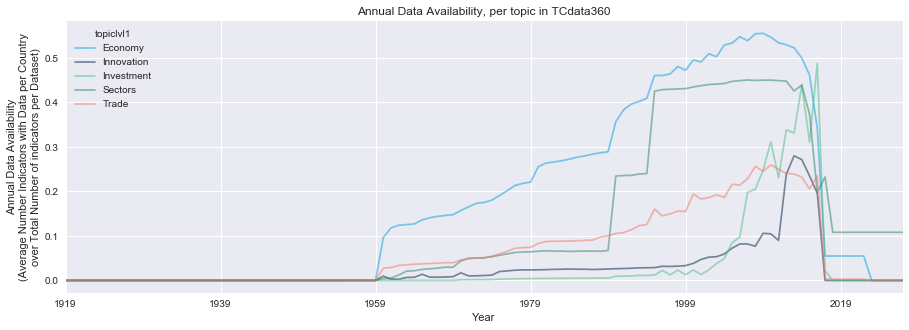

In [535]:
tc_topics[list_timeframe_all].T.plot(figsize=(15,5), alpha=0.5)
plt.title("Annual Data Availability, per topic in TCdata360")
plt.ylabel("Annual Data Availability\n(Average Number Indicators with Data per Country\nover Total Number of indicators per Dataset)")
plt.xlabel("Year")

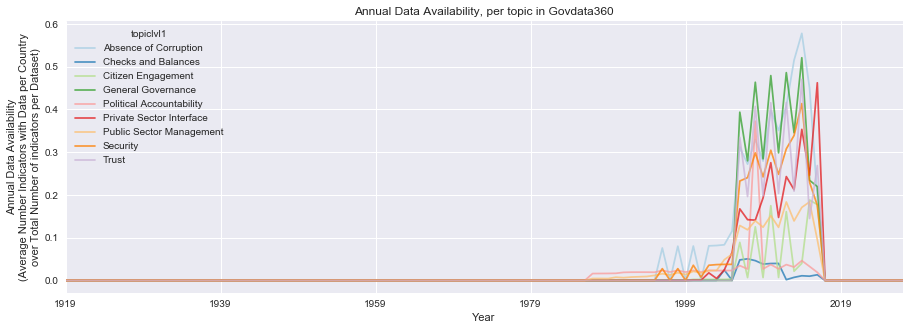

In [551]:
sns.set_palette(sns.color_palette("Paired", 9))
gv_topics[list_timeframe_all].T.plot(figsize=(15,5), alpha=0.75)
plt.title("Annual Data Availability, per topic in Govdata360")
plt.ylabel("Annual Data Availability\n(Average Number Indicators with Data per Country\nover Total Number of indicators per Dataset)")
plt.xlabel("Year")

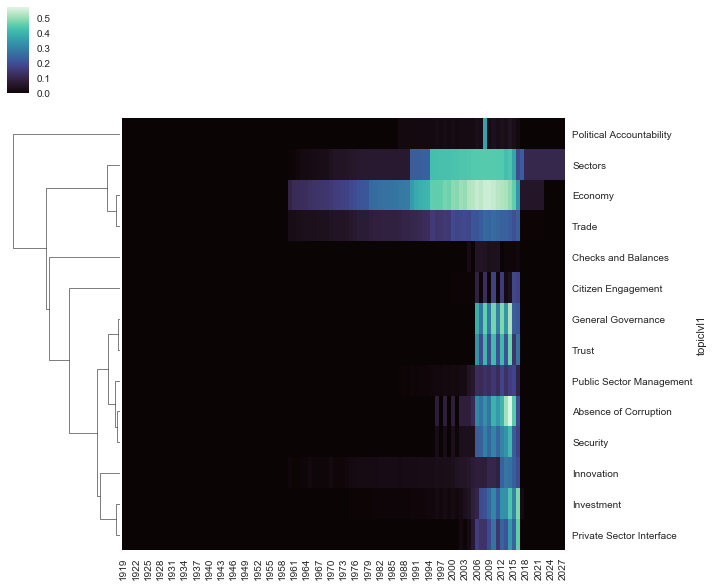

In [571]:
g = sns.clustermap(by_topic[list_timeframe_all], cmap="mako", col_cluster=False, metric ='cosine')

## Clustering topics by data availability over time

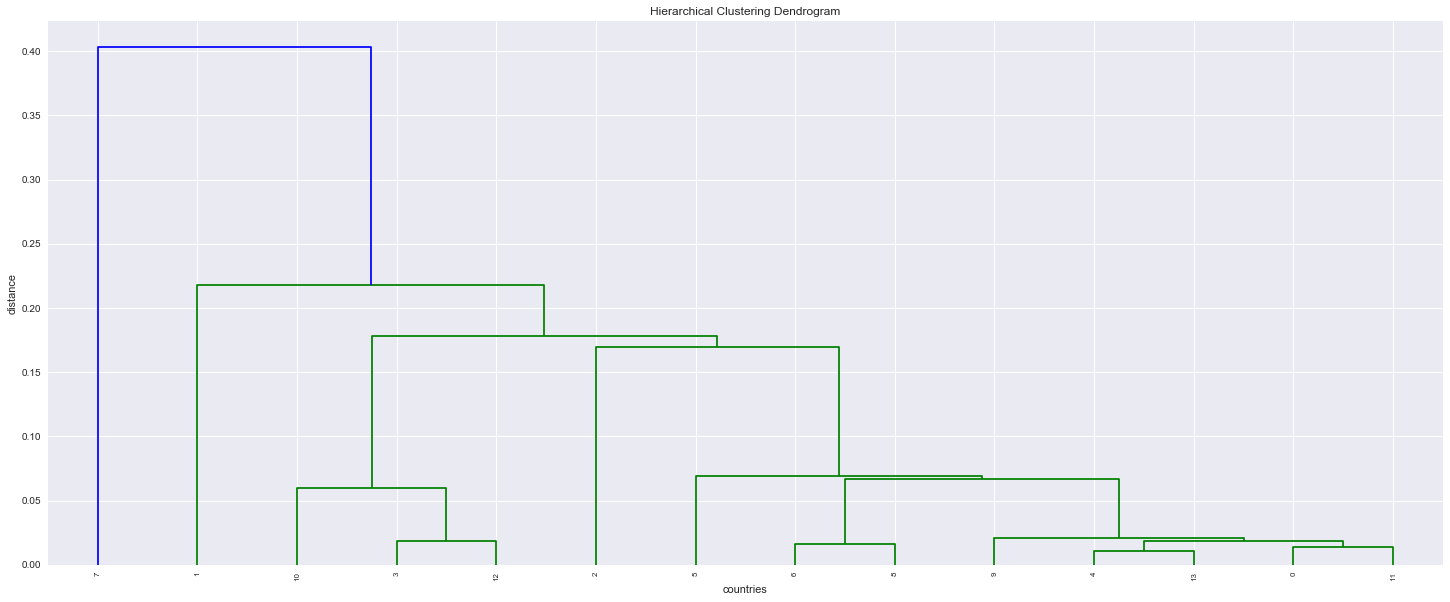

In [572]:
Z = hac.linkage(by_topic[list_timeframe_all], 'single', 'cosine')

# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

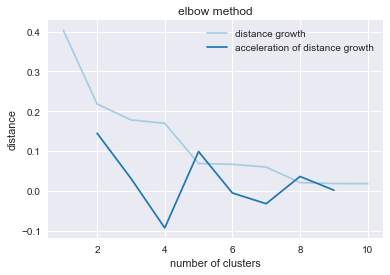

clusters: 2


In [573]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label='distance growth')

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label="acceleration of distance growth")
plt.legend()
plt.xlabel("number of clusters")
plt.ylabel("distance")
plt.title("elbow method")
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



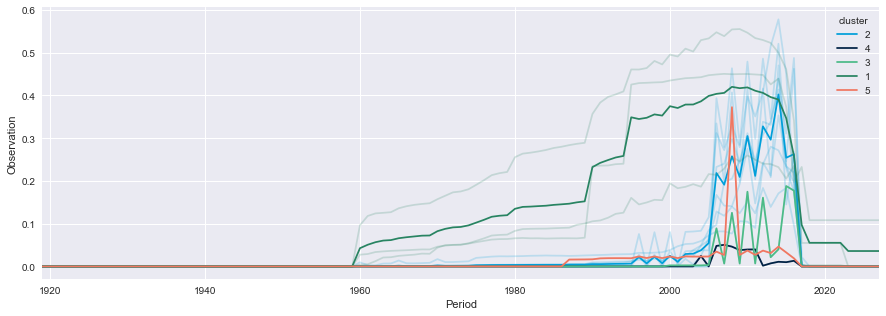

In [579]:
k=5
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_topic['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_topic_melt = pd.melt(by_topic.reset_index(),id_vars = ['topiclvl1', 'cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_topic_melt, time='Period', value='Observation', unit='topiclvl1', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.2})

In [580]:
by_topic['cluster'].value_counts()

2    8
1    3
5    1
4    1
3    1
Name: cluster, dtype: int64

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



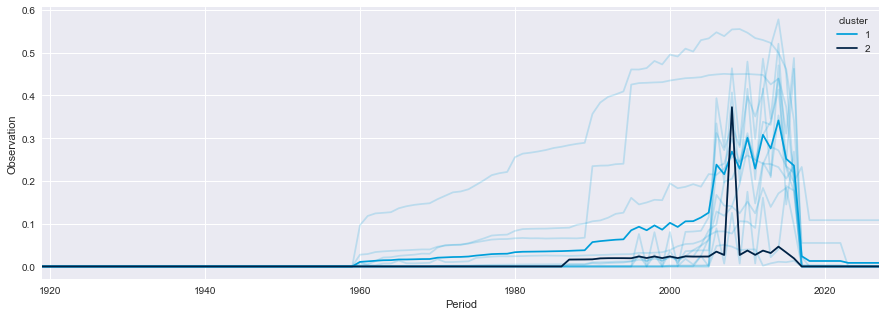

In [578]:
k=2
# by_country['cluster'] = hac.fcluster(Z, max_d, criterion='distance')
by_topic['cluster'] = hac.fcluster(Z, k, criterion='maxclust')
by_topic_melt = pd.melt(by_topic.reset_index(),id_vars = ['topiclvl1', 'cluster'],value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
# by_country_melt['Period'] = pd.to_datetime(by_country_melt['Period'], format="%Y")
plt.figure(figsize=(15,5))
sns.tsplot(data=by_topic_melt, time='Period', value='Observation', unit='topiclvl1', condition = 'cluster',
           err_style="unit_traces", color=wbg_cat_pal, err_kws = {'alpha': 0.2})

# Topic- and Country-level Data Analysis

In [592]:
topic_list = df_merged2['topiclvl1'].unique()

In [606]:
len(topic_list)

14

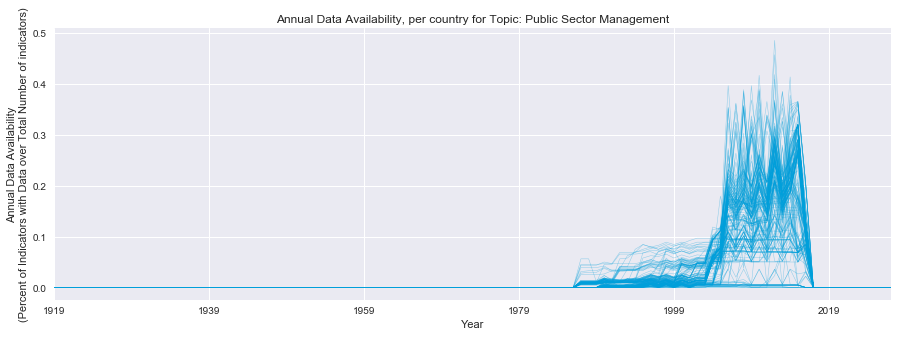

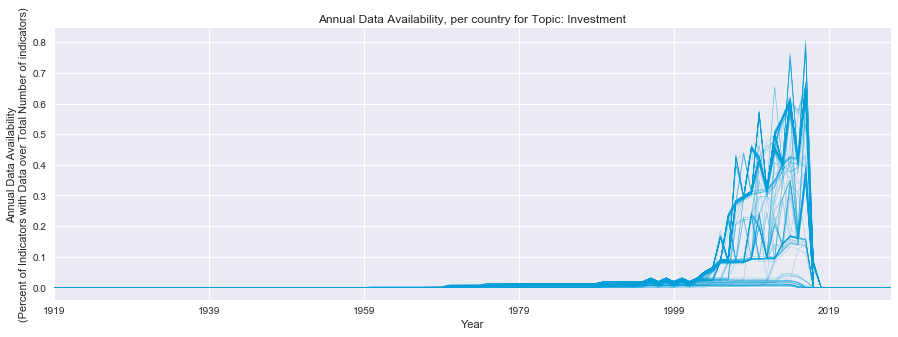

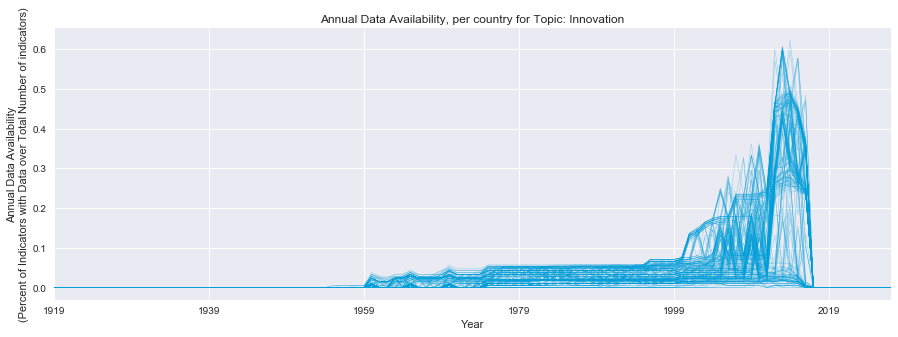

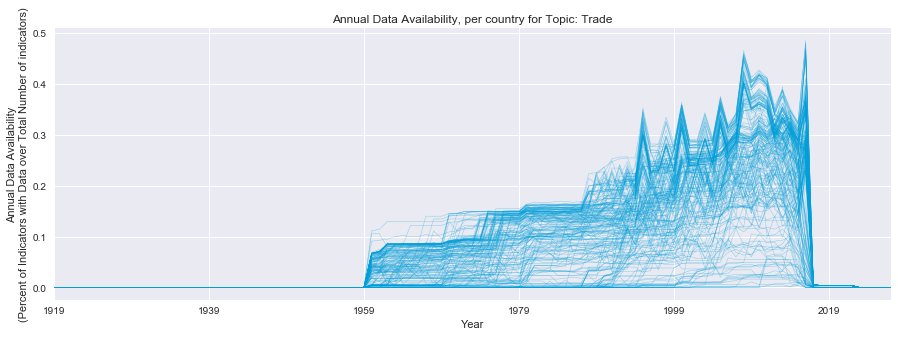

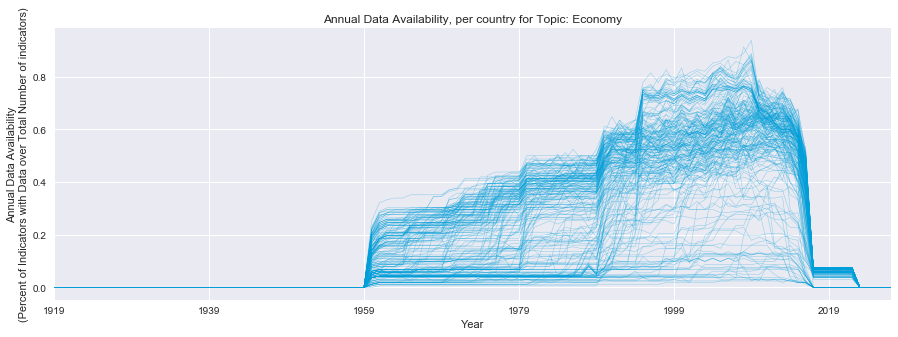

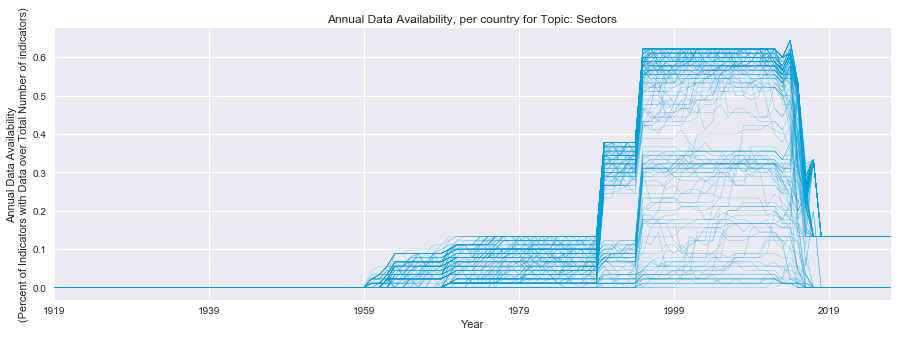

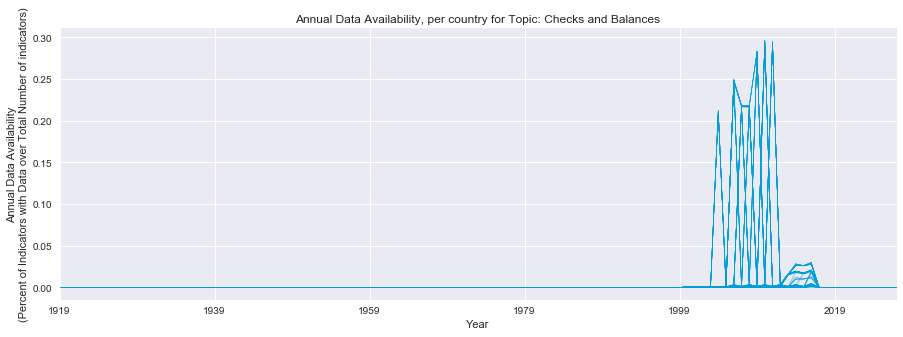

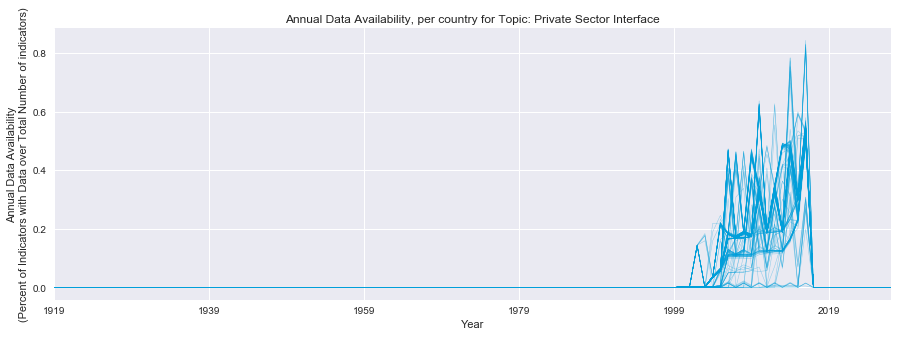

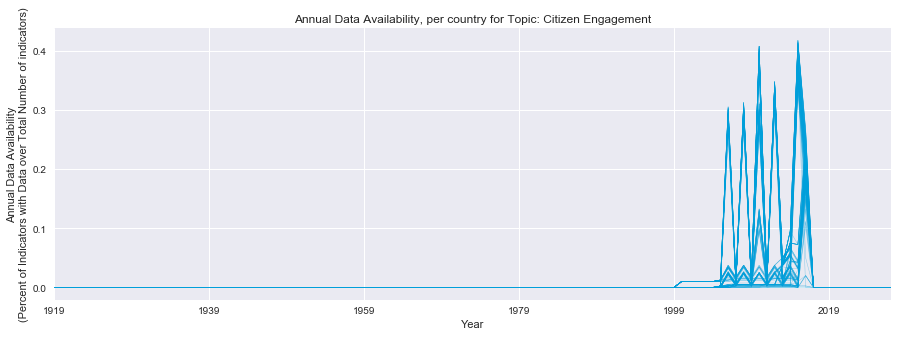

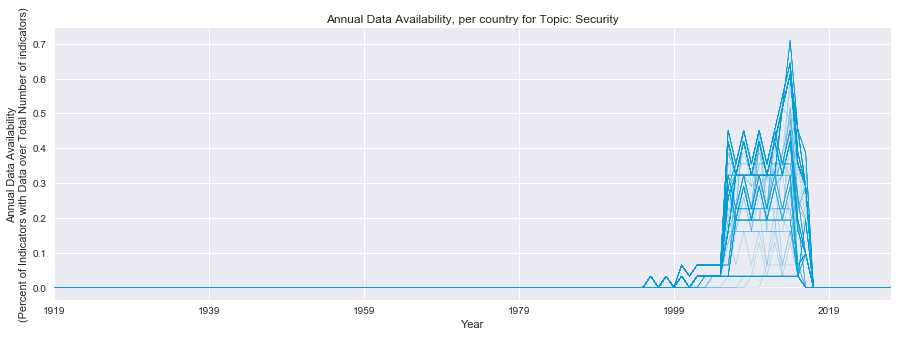

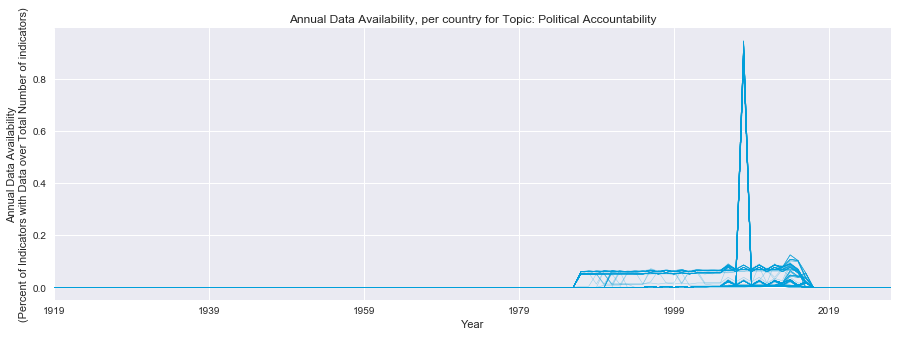

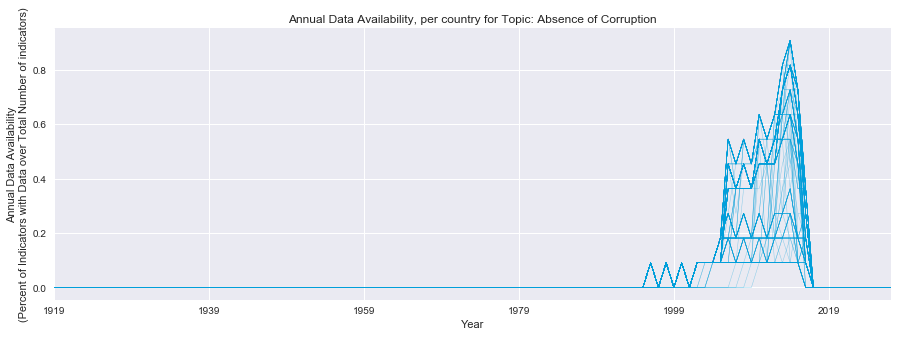

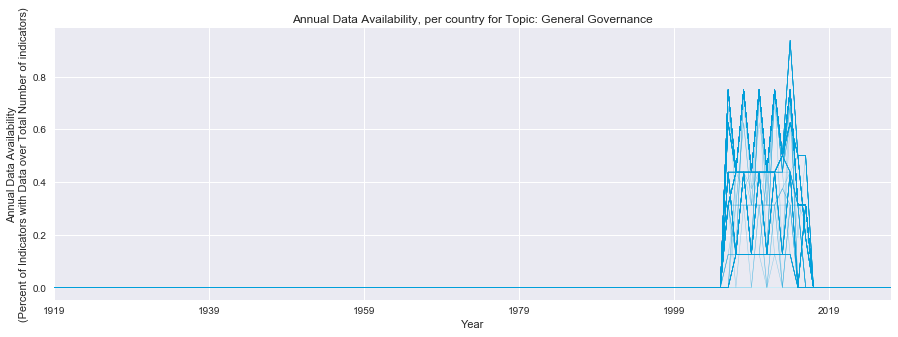

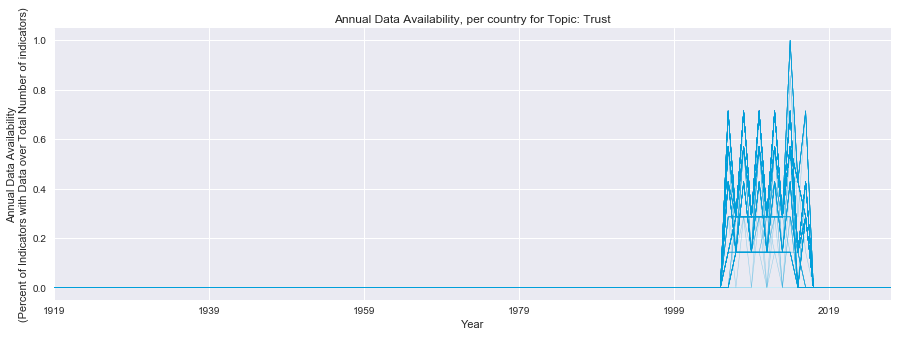

In [605]:
# topic = topic_list[0]
for topic in topic_list:
    indicators_per_topic = len(df_merged2[df_merged2['topiclvl1'] == topic]['indicatorId'].unique())
    by_country_topic = df_merged2[df_merged2['topiclvl1'] == topic].groupby('Country ISO3')[list_timeframe_all].sum()/indicators_per_topic
    by_country_topic[list_timeframe_all].T.plot(color='#009fda', lw=0.5, alpha=0.4, figsize=(15,5))
    plt.title("Annual Data Availability, per country for Topic: %s" % topic)
    plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
    plt.xlabel("Year")
    plt.legend([])
    plt.show()

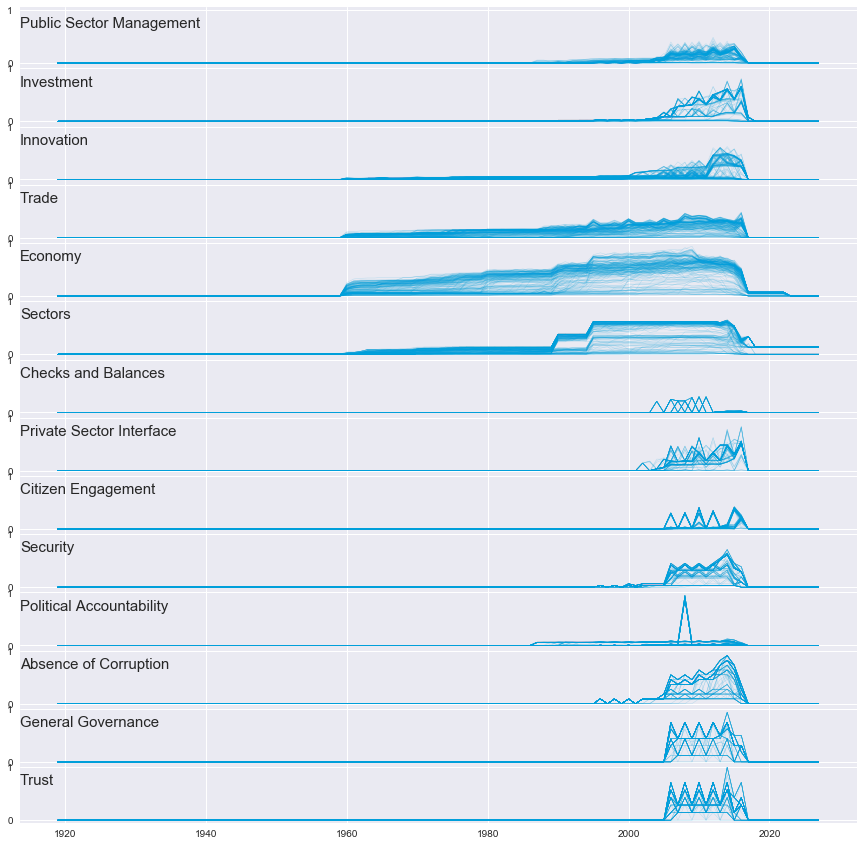

In [630]:
f, axarr = plt.subplots(14, sharex=True, sharey=True, figsize=(15,15))

count = 0
for topic in topic_list:
    indicators_per_topic = len(df_merged2[df_merged2['topiclvl1'] == topic]['indicatorId'].unique())
    by_country_topic = df_merged2[df_merged2['topiclvl1'] == topic].groupby('Country ISO3')[list_timeframe_all].sum()/indicators_per_topic
    axarr[count].plot(by_country_topic[list_timeframe_all].T, color='#009fda', lw=0.5, alpha=0.2)
    axarr[count].set_title("%s" % topic, loc='left', y=0.55,fontsize=15)
    count += 1

f.subplots_adjust(hspace=0)
plt.legend([])
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()